# Projeto Interpretabilidade de modelos 

Grupo:
- Lucas dos Reis Silva
- Gabriel Homci




## Conjunto de Dados

In [1]:
import pandas as pd
import os 
from rich import print as rprint
import numpy as np

In [2]:
# Load all CSV files
pasta = 'dataset'
arquivos = [f for f in os.listdir(pasta) if f.endswith('.csv')]

dfs = []
for arquivo in arquivos:
    caminho_completo = os.path.join(pasta, arquivo)
    df = pd.read_csv(caminho_completo)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

# Select and rename columns
column_map = {
    "Date": "match_date",
    "HomeTeam": "home_team",
    "AwayTeam": "away_team",
    "FTHG": "full_time_home_goals",
    "FTAG": "full_time_away_goals",
    "FTR": "full_time_result",
    "HS": "home_shots",
    "AS": "away_shots",
    "HST": "home_shots_on_target",
    "AST": "away_shots_on_target",
    "HC": "home_corners",
    "AC": "away_corners",
    "B365H": "b365_home",      
    "B365D": "b365_draw",      
    "B365A": "b365_away",
}

df = df[column_map.keys()].rename(columns=column_map)

# Encode teams
teams = sorted(df["home_team"].unique())
teams_map = {team: i+1 for i, team in enumerate(teams)}
teams_map_reverse = {i+1: team for i, team in enumerate(teams)}

# Encode results and dates
df['full_time_result'] = df['full_time_result'].map({'A': 0, 'D': 1, 'H': 2})
df['home_team'] = df['home_team'].map(teams_map)
df['away_team'] = df['away_team'].map(teams_map)
df['match_date'] = pd.to_datetime(df['match_date'], dayfirst=True)
df = df.sort_values('match_date').reset_index(drop=True)

In [3]:
df

,match_date,home_team,away_team,full_time_home_goals,full_time_away_goals,full_time_result,home_shots,away_shots,home_shots_on_target,away_shots_on_target,home_corners,away_corners,b365_home,b365_draw,b365_away
0,2021-08-13,4,1,2,0,2,8,22,3,4,2,5,4.00,3.40,1.95
1,2021-08-14,17,12,5,1,2,16,10,8,3,5,4,1.53,4.50,5.75
2,2021-08-14,6,5,1,2,0,14,14,3,8,7,6,3.10,3.10,2.45
3,2021-08-14,7,8,3,0,2,13,4,6,1,5,2,1.25,5.75,13.00
4,2021-08-14,9,22,3,1,2,14,6,6,3,6,8,1.90,3.50,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515,2025-05-25,11,25,1,3,0,14,10,4,6,4,0,3.00,3.80,2.20
1516,2025-05-25,10,16,0,2,0,13,20,3,5,1,6,5.00,4.20,1.60
1517,2025-05-25,3,13,2,0,2,20,3,7,0,6,1,1.33,5.25,8.50
1518,2025-05-25,14,8,1,1,1,14,8,3,5,11,0,1.40,6.00,5.75


In [4]:
def calculate_ewma(values, alpha=0.3):
    """Calculate exponentially weighted moving average"""
    weights = np.array([alpha * (1 - alpha)**i for i in range(len(values))])
    weights = weights / weights.sum()
    return np.sum(values * weights)

In [5]:
def extract_metrics_from_games(games_df, is_home=True):
    """
    Extract metrics from a list of games.
    
    Args:
        games_df: DataFrame of games to extract from
        is_home: If True, extract HOME team perspective; if False, AWAY team perspective
    
    Returns:
        Dict with goals_for, goals_against, shots, shots_target, corners
        or None if no games
    """
    
    if len(games_df) == 0:
        return None
    
    if is_home:
        # Extract metrics from HOME perspective
        goals_for = games_df['full_time_home_goals'].values
        goals_against = games_df['full_time_away_goals'].values
        shots = games_df['home_shots'].values
        shots_target = games_df['home_shots_on_target'].values
        corners = games_df['home_corners'].values
    else:
        # Extract metrics from AWAY perspective
        goals_for = games_df['full_time_away_goals'].values
        goals_against = games_df['full_time_home_goals'].values
        shots = games_df['away_shots'].values
        shots_target = games_df['away_shots_on_target'].values
        corners = games_df['away_corners'].values
    
    return {
        'goals_for': goals_for,
        'goals_against': goals_against,
        'shots': shots,
        'shots_target': shots_target,
        'corners': corners,
    }
    
def extract_overall_metrics_from_mixed_games(games_df, team_id):
    """
    Extract metrics from mixed games (team played both home and away).
    Converts all to the team's perspective.
    """
    
    if len(games_df) == 0:
        return None
    
    goals_for = []
    goals_against = []
    shots = []
    shots_target = []
    corners = []
    
    for _, game in games_df.iterrows():
        if game['home_team'] == team_id:
            # Team played at home
            goals_for.append(game['full_time_home_goals'])
            goals_against.append(game['full_time_away_goals'])
            shots.append(game['home_shots'])
            shots_target.append(game['home_shots_on_target'])
            corners.append(game['home_corners'])
        else:
            # Team played away
            goals_for.append(game['full_time_away_goals'])
            goals_against.append(game['full_time_home_goals'])
            shots.append(game['away_shots'])
            shots_target.append(game['away_shots_on_target'])
            corners.append(game['away_corners'])
    
    return {
        'goals_for': np.array(goals_for),
        'goals_against': np.array(goals_against),
        'shots': np.array(shots),
        'shots_target': np.array(shots_target),
        'corners': np.array(corners),
    }

In [6]:
dataset = []
window_size = 10
min_games_threshold = 1 
alpha = 0.3

for idx, row in df.iterrows():

    date = row["match_date"]
    home_team = row["home_team"]
    away_team = row["away_team"]
    result = row["full_time_result"]
    b365_home = row["b365_home"]
    b365_draw = row["b365_draw"]
    b365_away = row["b365_away"]
    
    
    # Get historical games (HOME team perspective)

    home_home_games = df[(df["home_team"] == home_team) & (df["match_date"] < date)].tail(window_size)
    home_overall_games = df[((df["home_team"] == home_team) | (df["away_team"] == home_team)) & (df["match_date"] < date)].tail(window_size)
    
    
    if len(home_home_games) >= 1:
        home_metrics = extract_metrics_from_games(home_home_games, is_home=True)
    else:
        home_metrics = extract_overall_metrics_from_mixed_games(home_overall_games, home_team)
    
    home_overall_metrics = extract_overall_metrics_from_mixed_games(home_overall_games, home_team)
    
    # Get historical games (AWAY team perspective)

    away_away_games = df[(df["away_team"] == away_team) & (df["match_date"] < date)].tail(window_size)
    away_overall_games = df[((df["home_team"] == away_team) | (df["away_team"] == away_team)) & (df["match_date"] < date)].tail(window_size)
    
    if len(away_away_games) >= 1:
        away_metrics = extract_metrics_from_games(away_away_games, is_home=False)
    else:
        away_metrics = extract_overall_metrics_from_mixed_games(away_overall_games, away_team)
    
    away_overall_metrics = extract_overall_metrics_from_mixed_games(away_overall_games, away_team)
    
    # Skip if insufficient data
    if (home_metrics is None or away_metrics is None or 
        home_overall_metrics is None or away_overall_metrics is None):
        continue
    
    # Build feature dictionary 

    features = {'date': date, 'result': result, "b365_home": b365_home, "b365_draw": b365_draw, "b365_away": b365_away}
    

    # HOME TEAM - Context-specific (home games)

    features['home_goals_for_ewma'] = calculate_ewma(home_metrics['goals_for'], alpha)
    features['home_goals_against_ewma'] = calculate_ewma(home_metrics['goals_against'], alpha)
    features['home_shots_ewma'] = calculate_ewma(home_metrics['shots'], alpha)
    features['home_shots_target_ewma'] = calculate_ewma(home_metrics['shots_target'], alpha)
    

    # AWAY TEAM - Context-specific (away games)

    features['away_goals_for_ewma'] = calculate_ewma(away_metrics['goals_for'], alpha)
    features['away_goals_against_ewma'] = calculate_ewma(away_metrics['goals_against'], alpha)
    features['away_shots_ewma'] = calculate_ewma(away_metrics['shots'], alpha)
    features['away_shots_target_ewma'] = calculate_ewma(away_metrics['shots_target'], alpha)
    

    # HOME TEAM - Overall form (all games mixed)

    features['home_overall_goals_for_ewma'] = calculate_ewma(home_overall_metrics['goals_for'], alpha)
    features['home_overall_goals_against_ewma'] = calculate_ewma(home_overall_metrics['goals_against'], alpha)
    features['home_overall_shots_ewma'] = calculate_ewma(home_overall_metrics['shots'], alpha)
    features['home_overall_shots_target_ewma'] = calculate_ewma(home_overall_metrics['shots_target'], alpha)
    

    # AWAY TEAM - Overall form (all games mixed)

    features['away_overall_goals_for_ewma'] = calculate_ewma(away_overall_metrics['goals_for'], alpha)
    features['away_overall_goals_against_ewma'] = calculate_ewma(away_overall_metrics['goals_against'], alpha)
    features['away_overall_shots_ewma'] = calculate_ewma(away_overall_metrics['shots'], alpha)
    features['away_overall_shots_target_ewma'] = calculate_ewma(away_overall_metrics['shots_target'], alpha)
    
    # Derived Features 
    
    # Goal differences
    features['home_goal_diff_ewma'] = features['home_goals_for_ewma'] - features['home_goals_against_ewma']
    features['away_goal_diff_ewma'] = features['away_goals_for_ewma'] - features['away_goals_against_ewma']
    features['home_overall_goal_diff_ewma'] = features['home_overall_goals_for_ewma'] - features['home_overall_goals_against_ewma']
    features['away_overall_goal_diff_ewma'] = features['away_overall_goals_for_ewma'] - features['away_overall_goals_against_ewma']
    
    # Shot accuracy
    features['home_shot_acc_ewma'] = features['home_shots_target_ewma'] / (features['home_shots_ewma'] + 0.001)
    features['away_shot_acc_ewma'] = features['away_shots_target_ewma'] / (features['away_shots_ewma'] + 0.001)
    features['home_overall_shot_acc_ewma'] = features['home_overall_shots_target_ewma'] / (features['home_overall_shots_ewma'] + 0.001)
    features['away_overall_shot_acc_ewma'] = features['away_overall_shots_target_ewma'] / (features['away_overall_shots_ewma'] + 0.001)
    
    # Win/Loss/Draw rates 
    home_wins = (home_metrics['goals_for'] - home_metrics['goals_against'] > 0).astype(int)
    home_draws = (home_metrics['goals_for'] - home_metrics['goals_against'] == 0).astype(int)
    home_losses = (home_metrics['goals_for'] - home_metrics['goals_against'] < 0).astype(int)
    
    away_wins = (away_metrics['goals_for'] - away_metrics['goals_against'] > 0).astype(int)
    away_draws = (away_metrics['goals_for'] - away_metrics['goals_against'] == 0).astype(int)
    away_losses = (away_metrics['goals_for'] - away_metrics['goals_against'] < 0).astype(int)
    
    features['home_win_rate_ewma'] = calculate_ewma(home_wins, alpha)
    features['home_draw_rate_ewma'] = calculate_ewma(home_draws, alpha)
    features['home_loss_rate_ewma'] = calculate_ewma(home_losses, alpha)
    
    features['away_win_rate_ewma'] = calculate_ewma(away_wins, alpha)
    features['away_draw_rate_ewma'] = calculate_ewma(away_draws, alpha)
    features['away_loss_rate_ewma'] = calculate_ewma(away_losses, alpha)
    
    # Overall win/loss/draw rates
    home_overall_wins = (home_overall_metrics['goals_for'] - home_overall_metrics['goals_against'] > 0).astype(int)
    away_overall_wins = (away_overall_metrics['goals_for'] - away_overall_metrics['goals_against'] > 0).astype(int)
    
    features['home_overall_win_rate_ewma'] = calculate_ewma(home_overall_wins, alpha)
    features['away_overall_win_rate_ewma'] = calculate_ewma(away_overall_wins, alpha)
    
    # Matchup Features

    features['goal_diff_matchup'] = features['home_goal_diff_ewma'] - features['away_goal_diff_ewma']
    features['shots_matchup'] = features['home_shots_ewma'] - features['away_shots_ewma']
    features['shot_acc_matchup'] = features['home_shot_acc_ewma'] - features['away_shot_acc_ewma']
    features['win_rate_diff'] = features['home_win_rate_ewma'] - features['away_win_rate_ewma']
    features['draw_rate_diff'] = features['home_draw_rate_ewma'] - features['away_draw_rate_ewma']
    features['overall_goal_diff_matchup'] = features['home_overall_goal_diff_ewma'] - features['away_overall_goal_diff_ewma']
    features['overall_shots_matchup'] = features['home_overall_shots_ewma'] - features['away_overall_shots_ewma']
    features['overall_win_rate_diff'] = features['home_overall_win_rate_ewma'] - features['away_overall_win_rate_ewma']
    
    dataset.append(features)

df_model = pd.DataFrame(dataset)
df_model

,date,result,b365_home,b365_draw,b365_away,home_goals_for_ewma,home_goals_against_ewma,home_shots_ewma,home_shots_target_ewma,away_goals_for_ewma,...,home_overall_win_rate_ewma,away_overall_win_rate_ewma,goal_diff_matchup,shots_matchup,shot_acc_matchup,win_rate_diff,draw_rate_diff,overall_goal_diff_matchup,overall_shots_matchup,overall_win_rate_diff
0,2021-08-21,2,1.70,3.50,5.75,2.000000,1.000000,14.000000,8.000000,3.000000,...,1.000000,1.000000,0.000000,1.000000,0.032968,0.000000,0.000000,0.000000,1.000000,0.000000
1,2021-08-21,2,1.08,11.00,26.00,0.000000,1.000000,18.000000,4.000000,0.000000,...,0.000000,0.000000,2.000000,4.000000,0.007939,0.000000,0.000000,2.000000,4.000000,0.000000
2,2021-08-21,1,2.37,3.40,3.00,1.000000,5.000000,10.000000,3.000000,3.000000,...,0.000000,1.000000,-6.000000,-4.000000,-0.128571,-1.000000,0.000000,-6.000000,-4.000000,-1.000000
3,2021-08-21,2,1.80,3.75,4.33,2.000000,3.000000,11.000000,2.000000,2.000000,...,0.000000,0.000000,1.000000,-6.000000,0.005341,0.000000,0.000000,1.000000,-6.000000,0.000000
4,2021-08-21,2,1.18,7.50,13.00,3.000000,0.000000,19.000000,8.000000,1.000000,...,1.000000,0.000000,4.000000,5.000000,0.206760,1.000000,0.000000,4.000000,5.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1499,2025-05-25,0,3.00,3.80,2.20,0.656285,2.808348,9.389872,3.741591,0.993934,...,0.151273,0.017797,-1.726077,-4.681782,0.165130,-0.179198,-0.203160,-0.507467,1.304194,0.133476
1500,2025-05-25,0,5.00,4.20,1.60,1.062172,1.142360,13.944922,4.894608,1.840427,...,0.370774,0.351487,-0.593688,-0.178361,-0.079135,-0.255810,0.486943,-0.466776,-3.665623,0.019288
1501,2025-05-25,2,1.33,5.25,8.50,1.103899,0.492576,16.484611,5.674074,0.903136,...,0.099548,0.037882,2.043327,9.999150,0.056286,0.241529,0.288635,1.351795,9.527202,0.061666
1502,2025-05-25,1,1.40,6.00,5.75,2.680224,1.118118,17.411427,5.734737,1.279823,...,0.838429,0.490249,0.678490,7.067258,-0.096803,0.211587,-0.149842,1.470807,5.455677,0.348180


In [7]:
cutoff_date = pd.to_datetime('2024-08-16')

train_df = df_model[df_model['date'] < cutoff_date].copy()
test_df = df_model[df_model['date'] >= cutoff_date].copy()

X_train = train_df.drop(columns=['result', 'date'])
y_train = train_df['result']
X_test = test_df.drop(columns=['result', 'date'])
y_test = test_df['result']

In [8]:
print(f"\n{'='*70}")
print("TRAIN/TEST SPLIT")
print(f"{'='*70}")
print(f"Training samples:     {len(X_train)}")
print(f"Test samples:         {len(X_test)}")
print(f"Features:             {X_train.shape[1]}")
print(f"Samples per feature:  {len(X_train) / X_train.shape[1]:.1f}")
print(f"\nClass distribution (train):")
for i, name in enumerate(['Away Win', 'Draw', 'Home Win']):
    count = sum(y_train == i)
    pct = count / len(y_train) * 100
    print(f"  {name:>12}  {count:>4} ({pct:>5.1f}%)")
print(f"{'='*70}")


TRAIN/TEST SPLIT
Training samples:     1125
Test samples:         379
Features:             43
Samples per feature:  26.2

Class distribution (train):
      Away Win   357 ( 31.7%)
          Draw   256 ( 22.8%)
      Home Win   512 ( 45.5%)


## Modelo

In [9]:
from xgboost import XGBClassifier
import numpy as np
import pandas as pd
import optuna
from optuna.integration import XGBoostPruningCallback
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import warnings
from xgboost.callback import EarlyStopping

RANDOM_STATE = 42

warnings.filterwarnings(
    "ignore",
    message="The reported value is ignored because this `step`",
    category=UserWarning,
    module="optuna.trial._trial"
)

a:\Documents\Mestrado\xAI-football-bet\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# Splitter
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)

# Class weights (same as antes)
class_counts = np.bincount(y_train)
total = len(y_train)
class_weights = total / (len(class_counts) * class_counts)
sample_weights = np.array([class_weights[label] for label in y_train])

In [14]:
# Optuna Objective usando XGBClassifier
def objective(trial, X_train, y_train, sample_weights, n_splits=n_splits):
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
    gamma = trial.suggest_float('gamma', 0.0, 0.5)
    reg_alpha = trial.suggest_float('reg_alpha', 0.0, 1.0)
    reg_lambda = trial.suggest_float('reg_lambda', 0.0, 1.0)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)

    params = {
        'max_depth': max_depth, 'min_child_weight': min_child_weight, 'learning_rate': learning_rate,
        'gamma': gamma, 'reg_alpha': reg_alpha, 'reg_lambda': reg_lambda,
        'subsample': subsample, 'colsample_bytree': colsample_bytree,
        'objective': 'multi:softprob', 'num_class': 3, 'eval_metric': 'mlogloss',
        'random_state': RANDOM_STATE, 'tree_method': 'hist', 'verbosity': 0
    }

    cv_scores = []
    for fold_num, (train_idx, val_idx) in enumerate(TimeSeriesSplit(n_splits=n_splits).split(X_train), 1):
        X_cv_train = X_train.iloc[train_idx]
        X_cv_val = X_train.iloc[val_idx]
        y_cv_train = y_train.iloc[train_idx]
        y_cv_val = y_train.iloc[val_idx]
        weights_cv_train = sample_weights[train_idx]

        model = XGBClassifier(**params, n_estimators=n_estimators, use_label_encoder=False)
        model.fit(X_cv_train, y_cv_train, sample_weight=weights_cv_train, verbose=False)
        y_pred = model.predict(X_cv_val)
        fold_f1 = f1_score(y_cv_val, y_pred, average='macro')
        cv_scores.append(fold_f1)
        trial.report(fold_f1, fold_num)
        if trial.should_prune():
            raise optuna.TrialPruned()
    mean_f1 = np.mean(cv_scores)
    return mean_f1

In [15]:

study = optuna.create_study(direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=2),
    study_name='xgboost_football_optuna')

[I 2025-11-04 22:54:10,962] A new study created in memory with name: xgboost_football_optuna


In [16]:
n_trials = 200
study.optimize(lambda trial: objective(
    trial, X_train, y_train, sample_weights, n_splits=3), n_trials=n_trials, show_progress_bar=True)

Best trial: 0. Best value: 0.426995:   0%|          | 1/200 [00:04<13:31,  4.08s/it]

[I 2025-11-04 22:54:16,273] Trial 0 finished with value: 0.42699497743604137 and parameters: {'max_depth': 5, 'min_child_weight': 10, 'learning_rate': 0.1205712628744377, 'n_estimators': 600, 'gamma': 0.07800932022121826, 'reg_alpha': 0.15599452033620265, 'reg_lambda': 0.05808361216819946, 'subsample': 0.9464704583099741, 'colsample_bytree': 0.8404460046972835}. Best is trial 0 with value: 0.42699497743604137.


Best trial: 0. Best value: 0.426995:   1%|          | 2/200 [00:07<12:00,  3.64s/it]

[I 2025-11-04 22:54:19,609] Trial 1 finished with value: 0.4247173337555214 and parameters: {'max_depth': 8, 'min_child_weight': 1, 'learning_rate': 0.2708160864249968, 'n_estimators': 900, 'gamma': 0.10616955533913808, 'reg_alpha': 0.18182496720710062, 'reg_lambda': 0.18340450985343382, 'subsample': 0.7216968971838151, 'colsample_bytree': 0.8099025726528951}. Best is trial 0 with value: 0.42699497743604137.


Best trial: 2. Best value: 0.444852:   2%|▏         | 3/200 [00:09<09:23,  2.86s/it]

[I 2025-11-04 22:54:21,539] Trial 2 finished with value: 0.44485219966834766 and parameters: {'max_depth': 6, 'min_child_weight': 3, 'learning_rate': 0.08012737503998542, 'n_estimators': 200, 'gamma': 0.14607232426760908, 'reg_alpha': 0.3663618432936917, 'reg_lambda': 0.45606998421703593, 'subsample': 0.9140703845572055, 'colsample_bytree': 0.6798695128633439}. Best is trial 2 with value: 0.44485219966834766.


Best trial: 2. Best value: 0.444852:   2%|▏         | 4/200 [00:19<19:05,  5.84s/it]

[I 2025-11-04 22:54:31,958] Trial 3 finished with value: 0.43130522949260497 and parameters: {'max_depth': 7, 'min_child_weight': 6, 'learning_rate': 0.011711509955524094, 'n_estimators': 700, 'gamma': 0.08526206184364576, 'reg_alpha': 0.06505159298527952, 'reg_lambda': 0.9488855372533332, 'subsample': 0.9862528132298237, 'colsample_bytree': 0.9233589392465844}. Best is trial 2 with value: 0.44485219966834766.


Best trial: 2. Best value: 0.444852:   2%|▎         | 5/200 [00:22<15:14,  4.69s/it]

[I 2025-11-04 22:54:34,593] Trial 4 finished with value: 0.41890737608983303 and parameters: {'max_depth': 5, 'min_child_weight': 1, 'learning_rate': 0.1024932221692416, 'n_estimators': 500, 'gamma': 0.06101911742238941, 'reg_alpha': 0.4951769101112702, 'reg_lambda': 0.034388521115218396, 'subsample': 0.9637281608315128, 'colsample_bytree': 0.7035119926400067}. Best is trial 2 with value: 0.44485219966834766.


Best trial: 2. Best value: 0.444852:   3%|▎         | 6/200 [00:27<15:11,  4.70s/it]

[I 2025-11-04 22:54:39,321] Trial 5 finished with value: 0.44091338045696976 and parameters: {'max_depth': 8, 'min_child_weight': 4, 'learning_rate': 0.05864129169696527, 'n_estimators': 600, 'gamma': 0.09242722776276352, 'reg_alpha': 0.9695846277645586, 'reg_lambda': 0.7751328233611146, 'subsample': 0.9757995766256756, 'colsample_bytree': 0.9579309401710595}. Best is trial 2 with value: 0.44485219966834766.


Best trial: 6. Best value: 0.464259:   4%|▎         | 7/200 [00:29<12:42,  3.95s/it]

[I 2025-11-04 22:54:41,727] Trial 6 finished with value: 0.46425929811245775 and parameters: {'max_depth': 7, 'min_child_weight': 10, 'learning_rate': 0.01351182947645082, 'n_estimators': 200, 'gamma': 0.022613644455269033, 'reg_alpha': 0.32533033076326434, 'reg_lambda': 0.388677289689482, 'subsample': 0.7085396127095583, 'colsample_bytree': 0.9314950036607718}. Best is trial 6 with value: 0.46425929811245775.


Best trial: 6. Best value: 0.464259:   4%|▍         | 8/200 [00:31<10:14,  3.20s/it]

[I 2025-11-04 22:54:43,314] Trial 7 finished with value: 0.4383590755563283 and parameters: {'max_depth': 5, 'min_child_weight': 3, 'learning_rate': 0.06333268775321843, 'n_estimators': 200, 'gamma': 0.40109849037701983, 'reg_alpha': 0.07455064367977082, 'reg_lambda': 0.9868869366005173, 'subsample': 0.908897907718663, 'colsample_bytree': 0.679486272613669}. Best is trial 6 with value: 0.46425929811245775.


Best trial: 6. Best value: 0.464259:   4%|▍         | 9/200 [00:34<10:47,  3.39s/it]

[I 2025-11-04 22:54:47,131] Trial 8 finished with value: 0.44594489331084036 and parameters: {'max_depth': 3, 'min_child_weight': 9, 'learning_rate': 0.11069143219393454, 'n_estimators': 800, 'gamma': 0.38563517334297287, 'reg_alpha': 0.07404465173409036, 'reg_lambda': 0.3584657285442726, 'subsample': 0.6463476238100518, 'colsample_bytree': 0.9452413703502374}. Best is trial 6 with value: 0.46425929811245775.


Best trial: 6. Best value: 0.464259:   5%|▌         | 10/200 [00:43<15:46,  4.98s/it]

[I 2025-11-04 22:54:55,681] Trial 9 finished with value: 0.4570206705243873 and parameters: {'max_depth': 7, 'min_child_weight': 4, 'learning_rate': 0.012413189635294229, 'n_estimators': 400, 'gamma': 0.16259166101337352, 'reg_alpha': 0.7296061783380641, 'reg_lambda': 0.6375574713552131, 'subsample': 0.9548850970305306, 'colsample_bytree': 0.7888859700647797}. Best is trial 6 with value: 0.46425929811245775.


Best trial: 6. Best value: 0.464259:   6%|▌         | 11/200 [00:45<12:25,  3.94s/it]

[I 2025-11-04 22:54:57,266] Trial 10 finished with value: 0.4630803811695318 and parameters: {'max_depth': 10, 'min_child_weight': 8, 'learning_rate': 0.02348130822266853, 'n_estimators': 100, 'gamma': 0.2828065453407016, 'reg_alpha': 0.3617675660384953, 'reg_lambda': 0.26768268871237144, 'subsample': 0.7569811568410529, 'colsample_bytree': 0.8675697628236403}. Best is trial 6 with value: 0.46425929811245775.


Best trial: 11. Best value: 0.467308:   6%|▌         | 12/200 [00:46<10:25,  3.33s/it]

[I 2025-11-04 22:54:59,191] Trial 11 finished with value: 0.46730763867621467 and parameters: {'max_depth': 10, 'min_child_weight': 8, 'learning_rate': 0.02304364042504696, 'n_estimators': 100, 'gamma': 0.277751009017812, 'reg_alpha': 0.37316855235034857, 'reg_lambda': 0.30729661211684867, 'subsample': 0.7888550785146621, 'colsample_bytree': 0.8826520438602498}. Best is trial 11 with value: 0.46730763867621467.


Best trial: 11. Best value: 0.467308:   6%|▋         | 13/200 [00:51<11:55,  3.83s/it]

[I 2025-11-04 22:55:04,156] Trial 12 finished with value: 0.4436850242615062 and parameters: {'max_depth': 10, 'min_child_weight': 7, 'learning_rate': 0.027398356773092405, 'n_estimators': 300, 'gamma': 0.2491440962769771, 'reg_alpha': 0.35339613832696065, 'reg_lambda': 0.5396201068027976, 'subsample': 0.8287411017635054, 'colsample_bytree': 0.9968509801053658}. Best is trial 11 with value: 0.46730763867621467.


Best trial: 13. Best value: 0.477449:   7%|▋         | 14/200 [00:53<09:31,  3.07s/it]

[I 2025-11-04 22:55:05,483] Trial 13 finished with value: 0.4774493236138721 and parameters: {'max_depth': 9, 'min_child_weight': 10, 'learning_rate': 0.025316204537589027, 'n_estimators': 100, 'gamma': 0.2696958675699548, 'reg_alpha': 0.6191678774040927, 'reg_lambda': 0.3610726345464689, 'subsample': 0.6526132043497838, 'colsample_bytree': 0.8989109117252714}. Best is trial 13 with value: 0.4774493236138721.


Best trial: 13. Best value: 0.477449:   8%|▊         | 15/200 [00:54<08:00,  2.59s/it]

[I 2025-11-04 22:55:06,978] Trial 14 finished with value: 0.46155789581909373 and parameters: {'max_depth': 9, 'min_child_weight': 8, 'learning_rate': 0.029781473093321076, 'n_estimators': 100, 'gamma': 0.49736142447726484, 'reg_alpha': 0.6657165197836602, 'reg_lambda': 0.5819444588317358, 'subsample': 0.6457695448473676, 'colsample_bytree': 0.7489736978203096}. Best is trial 13 with value: 0.4774493236138721.


Best trial: 13. Best value: 0.477449:   8%|▊         | 16/200 [00:59<09:30,  3.10s/it]

[I 2025-11-04 22:55:11,245] Trial 15 finished with value: 0.43585202476865614 and parameters: {'max_depth': 9, 'min_child_weight': 8, 'learning_rate': 0.03621285309135253, 'n_estimators': 400, 'gamma': 0.2532217884570004, 'reg_alpha': 0.6614071541642635, 'reg_lambda': 0.24980722058793503, 'subsample': 0.8402220888980981, 'colsample_bytree': 0.8685004592784907}. Best is trial 13 with value: 0.4774493236138721.


Best trial: 13. Best value: 0.477449:   8%|▊         | 17/200 [01:06<13:17,  4.36s/it]

[I 2025-11-04 22:55:18,532] Trial 16 pruned. 


Best trial: 13. Best value: 0.477449:   9%|▉         | 18/200 [01:10<12:38,  4.17s/it]

[I 2025-11-04 22:55:22,265] Trial 17 finished with value: 0.4465869559319036 and parameters: {'max_depth': 10, 'min_child_weight': 6, 'learning_rate': 0.040634129463030445, 'n_estimators': 300, 'gamma': 0.21692050801055723, 'reg_alpha': 0.8500702538042453, 'reg_lambda': 0.6712693880773244, 'subsample': 0.7838039444062148, 'colsample_bytree': 0.8853341327347025}. Best is trial 13 with value: 0.4774493236138721.


Best trial: 13. Best value: 0.477449:  10%|▉         | 19/200 [01:11<10:14,  3.39s/it]

[I 2025-11-04 22:55:23,845] Trial 18 pruned. 


Best trial: 13. Best value: 0.477449:  10%|█         | 20/200 [01:14<10:07,  3.38s/it]

[I 2025-11-04 22:55:27,189] Trial 19 finished with value: 0.44998370998884724 and parameters: {'max_depth': 9, 'min_child_weight': 9, 'learning_rate': 0.04346250608362959, 'n_estimators': 400, 'gamma': 0.4582408308181803, 'reg_alpha': 0.244543201589221, 'reg_lambda': 0.759581090544903, 'subsample': 0.8615535851701884, 'colsample_bytree': 0.9902497687459928}. Best is trial 13 with value: 0.4774493236138721.


Best trial: 13. Best value: 0.477449:  10%|█         | 21/200 [01:16<08:36,  2.88s/it]

[I 2025-11-04 22:55:28,924] Trial 20 finished with value: 0.46788054683028 and parameters: {'max_depth': 3, 'min_child_weight': 9, 'learning_rate': 0.016501479505930235, 'n_estimators': 300, 'gamma': 0.20208437711808128, 'reg_alpha': 0.5776500503617366, 'reg_lambda': 0.3194546623490381, 'subsample': 0.7539973340365145, 'colsample_bytree': 0.81384814951778}. Best is trial 13 with value: 0.4774493236138721.


Best trial: 13. Best value: 0.477449:  11%|█         | 22/200 [01:18<07:37,  2.57s/it]

[I 2025-11-04 22:55:30,759] Trial 21 finished with value: 0.4698779085371847 and parameters: {'max_depth': 3, 'min_child_weight': 9, 'learning_rate': 0.01677427227002354, 'n_estimators': 300, 'gamma': 0.19851837636077896, 'reg_alpha': 0.5806118959894186, 'reg_lambda': 0.31096504178418566, 'subsample': 0.7526597646391255, 'colsample_bytree': 0.8208197836165768}. Best is trial 13 with value: 0.4774493236138721.


Best trial: 13. Best value: 0.477449:  12%|█▏        | 23/200 [01:20<06:50,  2.32s/it]

[I 2025-11-04 22:55:32,492] Trial 22 finished with value: 0.47403832173566846 and parameters: {'max_depth': 3, 'min_child_weight': 9, 'learning_rate': 0.016664260722259353, 'n_estimators': 300, 'gamma': 0.19911522585521899, 'reg_alpha': 0.5958372768334322, 'reg_lambda': 0.1654159696089068, 'subsample': 0.7357164430245269, 'colsample_bytree': 0.8031125715949036}. Best is trial 13 with value: 0.4774493236138721.


Best trial: 13. Best value: 0.477449:  12%|█▏        | 24/200 [01:23<07:54,  2.70s/it]

[I 2025-11-04 22:55:36,070] Trial 23 finished with value: 0.46694654663904295 and parameters: {'max_depth': 4, 'min_child_weight': 10, 'learning_rate': 0.010680725697861108, 'n_estimators': 500, 'gamma': 0.17942623823306525, 'reg_alpha': 0.7528341251227558, 'reg_lambda': 0.15401637574566907, 'subsample': 0.6753943893690508, 'colsample_bytree': 0.7624916741387489}. Best is trial 13 with value: 0.4774493236138721.


Best trial: 13. Best value: 0.477449:  12%|█▎        | 25/200 [01:25<06:52,  2.36s/it]

[I 2025-11-04 22:55:37,640] Trial 24 pruned. 


Best trial: 13. Best value: 0.477449:  13%|█▎        | 26/200 [01:27<06:44,  2.32s/it]

[I 2025-11-04 22:55:39,880] Trial 25 finished with value: 0.4497814942874203 and parameters: {'max_depth': 4, 'min_child_weight': 7, 'learning_rate': 0.030144119028295203, 'n_estimators': 300, 'gamma': 0.2201219900800488, 'reg_alpha': 0.8291885190386503, 'reg_lambda': 0.10549546728553319, 'subsample': 0.6083971266710799, 'colsample_bytree': 0.7552033789375152}. Best is trial 13 with value: 0.4774493236138721.


Best trial: 13. Best value: 0.477449:  14%|█▎        | 27/200 [01:29<06:39,  2.31s/it]

[I 2025-11-04 22:55:42,150] Trial 26 pruned. 


Best trial: 13. Best value: 0.477449:  14%|█▍        | 28/200 [01:32<06:25,  2.24s/it]

[I 2025-11-04 22:55:44,235] Trial 27 finished with value: 0.4679133367754191 and parameters: {'max_depth': 6, 'min_child_weight': 10, 'learning_rate': 0.010222976203305353, 'n_estimators': 200, 'gamma': 0.24274727508819297, 'reg_alpha': 0.7368005145838272, 'reg_lambda': 0.5008523894620518, 'subsample': 0.729108972238306, 'colsample_bytree': 0.7858294551465761}. Best is trial 13 with value: 0.4774493236138721.


Best trial: 13. Best value: 0.477449:  14%|█▍        | 29/200 [01:35<07:43,  2.71s/it]

[I 2025-11-04 22:55:48,033] Trial 28 pruned. 


Best trial: 13. Best value: 0.477449:  15%|█▌        | 30/200 [01:38<07:48,  2.76s/it]

[I 2025-11-04 22:55:50,908] Trial 29 pruned. 


Best trial: 13. Best value: 0.477449:  16%|█▌        | 31/200 [01:41<07:51,  2.79s/it]

[I 2025-11-04 22:55:53,776] Trial 30 finished with value: 0.45225988437780934 and parameters: {'max_depth': 5, 'min_child_weight': 8, 'learning_rate': 0.03374124246333419, 'n_estimators': 300, 'gamma': 0.29075843447681143, 'reg_alpha': 0.8202641457605573, 'reg_lambda': 0.3026267894841525, 'subsample': 0.8250972026604596, 'colsample_bytree': 0.9131543817827914}. Best is trial 13 with value: 0.4774493236138721.


Best trial: 13. Best value: 0.477449:  16%|█▌        | 32/200 [01:44<07:35,  2.71s/it]

[I 2025-11-04 22:55:56,302] Trial 31 pruned. 


Best trial: 32. Best value: 0.479672:  16%|█▋        | 33/200 [01:45<06:15,  2.25s/it]

[I 2025-11-04 22:55:57,477] Trial 32 finished with value: 0.47967240535343597 and parameters: {'max_depth': 6, 'min_child_weight': 10, 'learning_rate': 0.017449115783546486, 'n_estimators': 100, 'gamma': 0.22916081028645147, 'reg_alpha': 0.5778503113689927, 'reg_lambda': 0.5184489274548447, 'subsample': 0.717273888656067, 'colsample_bytree': 0.7956480271796357}. Best is trial 32 with value: 0.47967240535343597.


Best trial: 33. Best value: 0.48389:  17%|█▋        | 34/200 [01:46<05:13,  1.89s/it] 

[I 2025-11-04 22:55:58,514] Trial 33 finished with value: 0.4838902629882198 and parameters: {'max_depth': 5, 'min_child_weight': 10, 'learning_rate': 0.017565137699501365, 'n_estimators': 100, 'gamma': 0.1679415210799681, 'reg_alpha': 0.5855589752224645, 'reg_lambda': 0.19966678678877442, 'subsample': 0.6418360301834134, 'colsample_bytree': 0.8162155113625206}. Best is trial 33 with value: 0.4838902629882198.


Best trial: 33. Best value: 0.48389:  18%|█▊        | 35/200 [01:47<04:29,  1.64s/it]

[I 2025-11-04 22:55:59,563] Trial 34 pruned. 


Best trial: 33. Best value: 0.48389:  18%|█▊        | 36/200 [01:48<04:06,  1.51s/it]

[I 2025-11-04 22:56:00,764] Trial 35 finished with value: 0.482628406581272 and parameters: {'max_depth': 5, 'min_child_weight': 10, 'learning_rate': 0.01789627862923207, 'n_estimators': 100, 'gamma': 0.12154778933555188, 'reg_alpha': 0.5576267343225454, 'reg_lambda': 0.13706475641919402, 'subsample': 0.675685125939113, 'colsample_bytree': 0.8041821774385604}. Best is trial 33 with value: 0.4838902629882198.


Best trial: 33. Best value: 0.48389:  18%|█▊        | 37/200 [01:49<03:38,  1.34s/it]

[I 2025-11-04 22:56:01,716] Trial 36 pruned. 


Best trial: 33. Best value: 0.48389:  19%|█▉        | 38/200 [01:50<03:22,  1.25s/it]

[I 2025-11-04 22:56:02,749] Trial 37 pruned. 


Best trial: 33. Best value: 0.48389:  20%|█▉        | 39/200 [01:52<03:48,  1.42s/it]

[I 2025-11-04 22:56:04,574] Trial 38 pruned. 


Best trial: 33. Best value: 0.48389:  20%|██        | 40/200 [01:54<04:08,  1.56s/it]

[I 2025-11-04 22:56:06,446] Trial 39 pruned. 


Best trial: 33. Best value: 0.48389:  20%|██        | 41/200 [01:55<03:59,  1.51s/it]

[I 2025-11-04 22:56:07,835] Trial 40 pruned. 


Best trial: 41. Best value: 0.484568:  21%|██        | 42/200 [01:56<03:36,  1.37s/it]

[I 2025-11-04 22:56:08,882] Trial 41 finished with value: 0.48456770607181426 and parameters: {'max_depth': 5, 'min_child_weight': 9, 'learning_rate': 0.018068005762203233, 'n_estimators': 100, 'gamma': 0.1616697029978928, 'reg_alpha': 0.5724532346944118, 'reg_lambda': 0.15390642263564927, 'subsample': 0.7217116977595066, 'colsample_bytree': 0.8025031034675189}. Best is trial 41 with value: 0.48456770607181426.


Best trial: 41. Best value: 0.484568:  22%|██▏       | 43/200 [01:57<03:16,  1.25s/it]

[I 2025-11-04 22:56:09,856] Trial 42 finished with value: 0.46771433782554683 and parameters: {'max_depth': 5, 'min_child_weight': 10, 'learning_rate': 0.01989885391819837, 'n_estimators': 100, 'gamma': 0.15273808460923877, 'reg_alpha': 0.4840300364037318, 'reg_lambda': 0.22478886995576824, 'subsample': 0.713808542882803, 'colsample_bytree': 0.8016741692625498}. Best is trial 41 with value: 0.48456770607181426.


Best trial: 41. Best value: 0.484568:  22%|██▏       | 44/200 [01:59<04:02,  1.55s/it]

[I 2025-11-04 22:56:12,111] Trial 43 finished with value: 0.4750271584425405 and parameters: {'max_depth': 6, 'min_child_weight': 9, 'learning_rate': 0.013722315372926544, 'n_estimators': 200, 'gamma': 0.12396751680528162, 'reg_alpha': 0.5531514373900718, 'reg_lambda': 0.11686609139127148, 'subsample': 0.6668404763293632, 'colsample_bytree': 0.7019956058545054}. Best is trial 41 with value: 0.48456770607181426.


Best trial: 41. Best value: 0.484568:  22%|██▎       | 45/200 [02:01<04:11,  1.62s/it]

[I 2025-11-04 22:56:13,895] Trial 44 finished with value: 0.4657726166704063 and parameters: {'max_depth': 5, 'min_child_weight': 10, 'learning_rate': 0.02316388699454613, 'n_estimators': 200, 'gamma': 0.22496236886460635, 'reg_alpha': 0.6857235487089757, 'reg_lambda': 0.2654530338937754, 'subsample': 0.6297369500838802, 'colsample_bytree': 0.851058840962671}. Best is trial 41 with value: 0.48456770607181426.


Best trial: 41. Best value: 0.484568:  23%|██▎       | 46/200 [02:02<03:35,  1.40s/it]

[I 2025-11-04 22:56:14,778] Trial 45 finished with value: 0.47646458610588877 and parameters: {'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.018320088449018567, 'n_estimators': 100, 'gamma': 0.0023902818998463166, 'reg_alpha': 0.6181721607182815, 'reg_lambda': 0.44057174563809337, 'subsample': 0.7139315349089707, 'colsample_bytree': 0.825113905920634}. Best is trial 41 with value: 0.48456770607181426.


Best trial: 41. Best value: 0.484568:  24%|██▎       | 47/200 [02:10<08:11,  3.22s/it]

[I 2025-11-04 22:56:22,230] Trial 46 pruned. 


Best trial: 41. Best value: 0.484568:  24%|██▍       | 48/200 [02:11<06:30,  2.57s/it]

[I 2025-11-04 22:56:23,300] Trial 47 pruned. 


Best trial: 41. Best value: 0.484568:  24%|██▍       | 49/200 [02:13<06:08,  2.44s/it]

[I 2025-11-04 22:56:25,423] Trial 48 finished with value: 0.4693729772868534 and parameters: {'max_depth': 5, 'min_child_weight': 8, 'learning_rate': 0.022368255511933548, 'n_estimators': 200, 'gamma': 0.23450808778419158, 'reg_alpha': 0.4842706772733984, 'reg_lambda': 0.5030761888126952, 'subsample': 0.6821331331151008, 'colsample_bytree': 0.7384933449724992}. Best is trial 41 with value: 0.48456770607181426.


Best trial: 41. Best value: 0.484568:  25%|██▌       | 50/200 [02:18<08:14,  3.30s/it]

[I 2025-11-04 22:56:30,719] Trial 49 finished with value: 0.45072896135429935 and parameters: {'max_depth': 7, 'min_child_weight': 4, 'learning_rate': 0.03389033572088721, 'n_estimators': 600, 'gamma': 0.27610252584829403, 'reg_alpha': 0.4078877365321336, 'reg_lambda': 0.001903206509718508, 'subsample': 0.773137189879132, 'colsample_bytree': 0.909263705324154}. Best is trial 41 with value: 0.48456770607181426.


Best trial: 41. Best value: 0.484568:  26%|██▌       | 51/200 [02:20<07:00,  2.82s/it]

[I 2025-11-04 22:56:32,429] Trial 50 pruned. 


Best trial: 41. Best value: 0.484568:  26%|██▌       | 52/200 [02:21<05:32,  2.25s/it]

[I 2025-11-04 22:56:33,346] Trial 51 finished with value: 0.47936298534723926 and parameters: {'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.018357205208457683, 'n_estimators': 100, 'gamma': 0.04063843192371728, 'reg_alpha': 0.6202796316600232, 'reg_lambda': 0.4297015257806682, 'subsample': 0.7134186488062406, 'colsample_bytree': 0.831486317376588}. Best is trial 41 with value: 0.48456770607181426.


Best trial: 41. Best value: 0.484568:  26%|██▋       | 53/200 [02:21<04:28,  1.83s/it]

[I 2025-11-04 22:56:34,195] Trial 52 finished with value: 0.4798518344923623 and parameters: {'max_depth': 4, 'min_child_weight': 10, 'learning_rate': 0.018022836681533774, 'n_estimators': 100, 'gamma': 0.042636731448880624, 'reg_alpha': 0.5543348728570802, 'reg_lambda': 0.41994892821357344, 'subsample': 0.7021617615190863, 'colsample_bytree': 0.8342908738088987}. Best is trial 41 with value: 0.48456770607181426.


Best trial: 41. Best value: 0.484568:  27%|██▋       | 54/200 [02:22<03:47,  1.56s/it]

[I 2025-11-04 22:56:35,127] Trial 53 finished with value: 0.48034642214717294 and parameters: {'max_depth': 4, 'min_child_weight': 9, 'learning_rate': 0.019420404880337548, 'n_estimators': 100, 'gamma': 0.037756232160777864, 'reg_alpha': 0.5122264549978929, 'reg_lambda': 0.5429808336970964, 'subsample': 0.7019089701456976, 'colsample_bytree': 0.8278840636335943}. Best is trial 41 with value: 0.48456770607181426.


Best trial: 41. Best value: 0.484568:  28%|██▊       | 55/200 [02:24<04:02,  1.67s/it]

[I 2025-11-04 22:56:37,063] Trial 54 finished with value: 0.47827832056965575 and parameters: {'max_depth': 5, 'min_child_weight': 9, 'learning_rate': 0.014464264558420304, 'n_estimators': 200, 'gamma': 0.009754176729983952, 'reg_alpha': 0.5418211136457959, 'reg_lambda': 0.7035896546881046, 'subsample': 0.6964452566600956, 'colsample_bytree': 0.8111489666570247}. Best is trial 41 with value: 0.48456770607181426.


Best trial: 41. Best value: 0.484568:  28%|██▊       | 56/200 [02:25<03:24,  1.42s/it]

[I 2025-11-04 22:56:37,897] Trial 55 finished with value: 0.48134954130718555 and parameters: {'max_depth': 4, 'min_child_weight': 10, 'learning_rate': 0.0202029443352115, 'n_estimators': 100, 'gamma': 0.06810732279204298, 'reg_alpha': 0.5016376029232056, 'reg_lambda': 0.14154611797370176, 'subsample': 0.7229802291453258, 'colsample_bytree': 0.857576598021284}. Best is trial 41 with value: 0.48456770607181426.


Best trial: 41. Best value: 0.484568:  28%|██▊       | 57/200 [02:26<03:00,  1.26s/it]

[I 2025-11-04 22:56:38,778] Trial 56 finished with value: 0.4775692108683425 and parameters: {'max_depth': 4, 'min_child_weight': 9, 'learning_rate': 0.019896590723818514, 'n_estimators': 100, 'gamma': 0.06345528085992926, 'reg_alpha': 0.5006351034367289, 'reg_lambda': 0.0642992733567691, 'subsample': 0.8013159821517055, 'colsample_bytree': 0.8648201935136999}. Best is trial 41 with value: 0.48456770607181426.


Best trial: 41. Best value: 0.484568:  29%|██▉       | 58/200 [02:28<03:10,  1.34s/it]

[I 2025-11-04 22:56:40,309] Trial 57 finished with value: 0.456769116272097 and parameters: {'max_depth': 4, 'min_child_weight': 6, 'learning_rate': 0.028496362651533148, 'n_estimators': 200, 'gamma': 0.033539746996900405, 'reg_alpha': 0.014117513645384105, 'reg_lambda': 0.13151519311310547, 'subsample': 0.6646273799563832, 'colsample_bytree': 0.8493508697842131}. Best is trial 41 with value: 0.48456770607181426.


Best trial: 41. Best value: 0.484568:  30%|██▉       | 59/200 [02:30<03:35,  1.53s/it]

[I 2025-11-04 22:56:42,265] Trial 58 finished with value: 0.4658968669654932 and parameters: {'max_depth': 4, 'min_child_weight': 3, 'learning_rate': 0.023770621502039443, 'n_estimators': 200, 'gamma': 0.09703726109806257, 'reg_alpha': 0.32150439605380365, 'reg_lambda': 0.18181438929127788, 'subsample': 0.7453968639426604, 'colsample_bytree': 0.8809075087830784}. Best is trial 41 with value: 0.48456770607181426.


Best trial: 41. Best value: 0.484568:  30%|███       | 60/200 [02:35<06:07,  2.62s/it]

[I 2025-11-04 22:56:47,455] Trial 59 pruned. 


Best trial: 41. Best value: 0.484568:  30%|███       | 61/200 [02:36<04:56,  2.13s/it]

[I 2025-11-04 22:56:48,431] Trial 60 pruned. 


Best trial: 41. Best value: 0.484568:  31%|███       | 62/200 [02:37<04:04,  1.77s/it]

[I 2025-11-04 22:56:49,365] Trial 61 finished with value: 0.4815261742355374 and parameters: {'max_depth': 5, 'min_child_weight': 10, 'learning_rate': 0.017378351317341098, 'n_estimators': 100, 'gamma': 0.0889527897953997, 'reg_alpha': 0.5673548735543564, 'reg_lambda': 0.5262367892245978, 'subsample': 0.7262539369007968, 'colsample_bytree': 0.7894292927043473}. Best is trial 41 with value: 0.48456770607181426.


Best trial: 41. Best value: 0.484568:  32%|███▏      | 63/200 [02:38<03:29,  1.53s/it]

[I 2025-11-04 22:56:50,325] Trial 62 pruned. 


Best trial: 41. Best value: 0.484568:  32%|███▏      | 64/200 [02:39<03:28,  1.54s/it]

[I 2025-11-04 22:56:51,879] Trial 63 finished with value: 0.4799208427524222 and parameters: {'max_depth': 4, 'min_child_weight': 9, 'learning_rate': 0.012016315079513114, 'n_estimators': 200, 'gamma': 0.022887007250052434, 'reg_alpha': 0.5141622998970266, 'reg_lambda': 0.5945966183796275, 'subsample': 0.6817374715870699, 'colsample_bytree': 0.7908042812653522}. Best is trial 41 with value: 0.48456770607181426.


Best trial: 41. Best value: 0.484568:  32%|███▎      | 65/200 [02:41<03:19,  1.48s/it]

[I 2025-11-04 22:56:53,217] Trial 64 finished with value: 0.47319956744712516 and parameters: {'max_depth': 3, 'min_child_weight': 9, 'learning_rate': 0.011276064693080774, 'n_estimators': 200, 'gamma': 0.11949667376907766, 'reg_alpha': 0.46800784988366506, 'reg_lambda': 0.5509603236440941, 'subsample': 0.6826838421269162, 'colsample_bytree': 0.7917711719585537}. Best is trial 41 with value: 0.48456770607181426.


Best trial: 41. Best value: 0.484568:  33%|███▎      | 66/200 [02:42<03:01,  1.36s/it]

[I 2025-11-04 22:56:54,292] Trial 65 pruned. 


Best trial: 41. Best value: 0.484568:  34%|███▎      | 67/200 [02:44<03:30,  1.58s/it]

[I 2025-11-04 22:56:56,390] Trial 66 finished with value: 0.47245942303354216 and parameters: {'max_depth': 5, 'min_child_weight': 8, 'learning_rate': 0.015368200809393025, 'n_estimators': 200, 'gamma': 0.02363251566821873, 'reg_alpha': 0.5204788371628838, 'reg_lambda': 0.6767586699010393, 'subsample': 0.878614672221482, 'colsample_bytree': 0.8182117730803931}. Best is trial 41 with value: 0.48456770607181426.


Best trial: 41. Best value: 0.484568:  34%|███▍      | 68/200 [02:46<04:00,  1.83s/it]

[I 2025-11-04 22:56:58,793] Trial 67 pruned. 


Best trial: 41. Best value: 0.484568:  34%|███▍      | 69/200 [02:47<03:15,  1.49s/it]

[I 2025-11-04 22:56:59,503] Trial 68 finished with value: 0.4762986292138862 and parameters: {'max_depth': 3, 'min_child_weight': 5, 'learning_rate': 0.01583705535167548, 'n_estimators': 100, 'gamma': 0.11411086078209104, 'reg_alpha': 0.5877396208164043, 'reg_lambda': 0.18915887843556659, 'subsample': 0.6573089169004775, 'colsample_bytree': 0.7681068993496909}. Best is trial 41 with value: 0.48456770607181426.


Best trial: 41. Best value: 0.484568:  35%|███▌      | 70/200 [02:48<02:56,  1.36s/it]

[I 2025-11-04 22:57:00,547] Trial 69 finished with value: 0.47821326268887393 and parameters: {'max_depth': 5, 'min_child_weight': 9, 'learning_rate': 0.024811666558793632, 'n_estimators': 100, 'gamma': 0.13457087351732885, 'reg_alpha': 0.6549369053078478, 'reg_lambda': 0.5336649578193466, 'subsample': 0.675066452941501, 'colsample_bytree': 0.7396440481222178}. Best is trial 41 with value: 0.48456770607181426.


Best trial: 41. Best value: 0.484568:  36%|███▌      | 71/200 [02:51<03:45,  1.75s/it]

[I 2025-11-04 22:57:03,212] Trial 70 pruned. 


Best trial: 41. Best value: 0.484568:  36%|███▌      | 72/200 [02:51<03:09,  1.48s/it]

[I 2025-11-04 22:57:04,075] Trial 71 finished with value: 0.47896593863182985 and parameters: {'max_depth': 4, 'min_child_weight': 10, 'learning_rate': 0.01775454136582373, 'n_estimators': 100, 'gamma': 0.05215315698099253, 'reg_alpha': 0.5531717629562641, 'reg_lambda': 0.47954490649412906, 'subsample': 0.6197942272359523, 'colsample_bytree': 0.8359254260743301}. Best is trial 41 with value: 0.48456770607181426.


Best trial: 41. Best value: 0.484568:  36%|███▋      | 73/200 [02:52<02:46,  1.31s/it]

[I 2025-11-04 22:57:04,979] Trial 72 finished with value: 0.469058967309332 and parameters: {'max_depth': 4, 'min_child_weight': 10, 'learning_rate': 0.019132100432482528, 'n_estimators': 100, 'gamma': 0.0266988820663638, 'reg_alpha': 0.5209789511203804, 'reg_lambda': 0.2725776571339378, 'subsample': 0.7045437327938169, 'colsample_bytree': 0.8253862601331495}. Best is trial 41 with value: 0.48456770607181426.


Best trial: 41. Best value: 0.484568:  37%|███▋      | 74/200 [02:53<02:22,  1.13s/it]

[I 2025-11-04 22:57:05,704] Trial 73 pruned. 


Best trial: 41. Best value: 0.484568:  38%|███▊      | 75/200 [02:55<02:49,  1.36s/it]

[I 2025-11-04 22:57:07,587] Trial 74 pruned. 


Best trial: 41. Best value: 0.484568:  38%|███▊      | 76/200 [02:57<03:01,  1.46s/it]

[I 2025-11-04 22:57:09,293] Trial 75 finished with value: 0.47976813208079455 and parameters: {'max_depth': 4, 'min_child_weight': 10, 'learning_rate': 0.01736014143945764, 'n_estimators': 200, 'gamma': 0.05226112521961408, 'reg_alpha': 0.4314907086855566, 'reg_lambda': 0.835516636605262, 'subsample': 0.6422339398343444, 'colsample_bytree': 0.8037347465275443}. Best is trial 41 with value: 0.48456770607181426.


Best trial: 41. Best value: 0.484568:  38%|███▊      | 77/200 [02:57<02:31,  1.23s/it]

[I 2025-11-04 22:57:09,991] Trial 76 pruned. 


Best trial: 41. Best value: 0.484568:  39%|███▉      | 78/200 [02:58<02:04,  1.02s/it]

[I 2025-11-04 22:57:10,522] Trial 77 pruned. 


Best trial: 41. Best value: 0.484568:  40%|███▉      | 79/200 [03:04<04:55,  2.44s/it]

[I 2025-11-04 22:57:16,270] Trial 78 pruned. 


Best trial: 41. Best value: 0.484568:  40%|████      | 80/200 [03:06<04:50,  2.42s/it]

[I 2025-11-04 22:57:18,638] Trial 79 pruned. 


Best trial: 41. Best value: 0.484568:  40%|████      | 81/200 [03:07<03:56,  1.99s/it]

[I 2025-11-04 22:57:19,631] Trial 80 finished with value: 0.47983844501108136 and parameters: {'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.021575575786188916, 'n_estimators': 100, 'gamma': 0.0368554123337787, 'reg_alpha': 0.608778423642082, 'reg_lambda': 0.41687314930263974, 'subsample': 0.7382712164688243, 'colsample_bytree': 0.7827652121931999}. Best is trial 41 with value: 0.48456770607181426.


Best trial: 41. Best value: 0.484568:  41%|████      | 82/200 [03:08<03:21,  1.70s/it]

[I 2025-11-04 22:57:20,667] Trial 81 finished with value: 0.47238666659123457 and parameters: {'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.02186776851537048, 'n_estimators': 100, 'gamma': 0.03922247752672461, 'reg_alpha': 0.620432311063742, 'reg_lambda': 0.48906937707439907, 'subsample': 0.9967704888724043, 'colsample_bytree': 0.7835578810795387}. Best is trial 41 with value: 0.48456770607181426.


Best trial: 41. Best value: 0.484568:  42%|████▏     | 83/200 [03:09<02:50,  1.45s/it]

[I 2025-11-04 22:57:21,540] Trial 82 pruned. 


Best trial: 41. Best value: 0.484568:  42%|████▏     | 84/200 [03:10<02:38,  1.36s/it]

[I 2025-11-04 22:57:22,690] Trial 83 finished with value: 0.47929916308438686 and parameters: {'max_depth': 5, 'min_child_weight': 7, 'learning_rate': 0.013161762912907224, 'n_estimators': 100, 'gamma': 0.060220190116721806, 'reg_alpha': 0.6015992441144973, 'reg_lambda': 0.535705127453389, 'subsample': 0.7037225655405874, 'colsample_bytree': 0.8019408291172877}. Best is trial 41 with value: 0.48456770607181426.


Best trial: 41. Best value: 0.484568:  42%|████▎     | 85/200 [03:11<02:13,  1.16s/it]

[I 2025-11-04 22:57:23,390] Trial 84 finished with value: 0.47683743860527933 and parameters: {'max_depth': 3, 'min_child_weight': 9, 'learning_rate': 0.02346873774474751, 'n_estimators': 100, 'gamma': 0.032510672090589804, 'reg_alpha': 0.5616971076505209, 'reg_lambda': 0.4640231180964517, 'subsample': 0.7633697823235257, 'colsample_bytree': 0.7606118140418758}. Best is trial 41 with value: 0.48456770607181426.


Best trial: 41. Best value: 0.484568:  43%|████▎     | 86/200 [03:12<02:31,  1.33s/it]

[I 2025-11-04 22:57:25,102] Trial 85 pruned. 


Best trial: 41. Best value: 0.484568:  44%|████▎     | 87/200 [03:14<02:24,  1.28s/it]

[I 2025-11-04 22:57:26,258] Trial 86 finished with value: 0.47831963389461013 and parameters: {'max_depth': 5, 'min_child_weight': 10, 'learning_rate': 0.014621592292340254, 'n_estimators': 100, 'gamma': 0.05545678038942626, 'reg_alpha': 0.4211482111404008, 'reg_lambda': 0.12752602230833343, 'subsample': 0.6743468933741927, 'colsample_bytree': 0.8268985626433628}. Best is trial 41 with value: 0.48456770607181426.


Best trial: 41. Best value: 0.484568:  44%|████▍     | 88/200 [03:16<02:45,  1.48s/it]

[I 2025-11-04 22:57:28,201] Trial 87 pruned. 


Best trial: 41. Best value: 0.484568:  44%|████▍     | 89/200 [03:20<04:14,  2.30s/it]

[I 2025-11-04 22:57:32,408] Trial 88 pruned. 


Best trial: 41. Best value: 0.484568:  45%|████▌     | 90/200 [03:21<03:33,  1.94s/it]

[I 2025-11-04 22:57:33,537] Trial 89 pruned. 


Best trial: 41. Best value: 0.484568:  46%|████▌     | 91/200 [03:22<03:08,  1.73s/it]

[I 2025-11-04 22:57:34,764] Trial 90 finished with value: 0.4690131506201107 and parameters: {'max_depth': 3, 'min_child_weight': 9, 'learning_rate': 0.026125935360930812, 'n_estimators': 200, 'gamma': 0.18294595220120363, 'reg_alpha': 0.49440490449990065, 'reg_lambda': 0.3992880789304839, 'subsample': 0.6960336261421196, 'colsample_bytree': 0.8080140196889771}. Best is trial 41 with value: 0.48456770607181426.


Best trial: 41. Best value: 0.484568:  46%|████▌     | 92/200 [03:24<03:00,  1.67s/it]

[I 2025-11-04 22:57:36,309] Trial 91 pruned. 


Best trial: 41. Best value: 0.484568:  46%|████▋     | 93/200 [03:24<02:32,  1.43s/it]

[I 2025-11-04 22:57:37,157] Trial 92 finished with value: 0.47731987737786846 and parameters: {'max_depth': 4, 'min_child_weight': 10, 'learning_rate': 0.017366419856184957, 'n_estimators': 100, 'gamma': 0.03983771793439715, 'reg_alpha': 0.5711930559783558, 'reg_lambda': 0.9330927647486973, 'subsample': 0.6173524590003913, 'colsample_bytree': 0.7903931765149589}. Best is trial 41 with value: 0.48456770607181426.


Best trial: 41. Best value: 0.484568:  47%|████▋     | 94/200 [03:25<02:14,  1.27s/it]

[I 2025-11-04 22:57:38,068] Trial 93 finished with value: 0.48369392381192616 and parameters: {'max_depth': 4, 'min_child_weight': 10, 'learning_rate': 0.021026837054376243, 'n_estimators': 100, 'gamma': 0.06765206129645593, 'reg_alpha': 0.6284183939611304, 'reg_lambda': 0.8045030423437471, 'subsample': 0.6558940321706861, 'colsample_bytree': 0.8207551845849255}. Best is trial 41 with value: 0.48456770607181426.


Best trial: 41. Best value: 0.484568:  48%|████▊     | 95/200 [03:26<02:05,  1.20s/it]

[I 2025-11-04 22:57:39,089] Trial 94 finished with value: 0.4746247588137511 and parameters: {'max_depth': 5, 'min_child_weight': 10, 'learning_rate': 0.021547845196659778, 'n_estimators': 100, 'gamma': 0.2106974634131566, 'reg_alpha': 0.7138593347240922, 'reg_lambda': 0.7952626262442104, 'subsample': 0.6524541952021117, 'colsample_bytree': 0.8202190418078888}. Best is trial 41 with value: 0.48456770607181426.


Best trial: 41. Best value: 0.484568:  48%|████▊     | 96/200 [03:27<01:53,  1.09s/it]

[I 2025-11-04 22:57:39,926] Trial 95 pruned. 


Best trial: 41. Best value: 0.484568:  48%|████▊     | 97/200 [03:28<01:43,  1.01s/it]

[I 2025-11-04 22:57:40,747] Trial 96 finished with value: 0.4787573326743606 and parameters: {'max_depth': 4, 'min_child_weight': 10, 'learning_rate': 0.019377771714994278, 'n_estimators': 100, 'gamma': 0.08425224399336026, 'reg_alpha': 0.6367118904607811, 'reg_lambda': 0.4396350358242269, 'subsample': 0.6583996639334234, 'colsample_bytree': 0.8335487625984346}. Best is trial 41 with value: 0.48456770607181426.


Best trial: 41. Best value: 0.484568:  49%|████▉     | 98/200 [03:29<01:32,  1.11it/s]

[I 2025-11-04 22:57:41,410] Trial 97 pruned. 


Best trial: 41. Best value: 0.484568:  50%|████▉     | 99/200 [03:30<01:49,  1.09s/it]

[I 2025-11-04 22:57:42,920] Trial 98 pruned. 


Best trial: 41. Best value: 0.484568:  50%|█████     | 100/200 [03:35<03:28,  2.08s/it]

[I 2025-11-04 22:57:47,336] Trial 99 pruned. 


Best trial: 41. Best value: 0.484568:  50%|█████     | 101/200 [03:36<02:50,  1.73s/it]

[I 2025-11-04 22:57:48,225] Trial 100 finished with value: 0.477162117566567 and parameters: {'max_depth': 4, 'min_child_weight': 9, 'learning_rate': 0.014084037051330189, 'n_estimators': 100, 'gamma': 0.12247923155689645, 'reg_alpha': 0.5111651432074219, 'reg_lambda': 0.10381331924754407, 'subsample': 0.6856362603856087, 'colsample_bytree': 0.7953878936130825}. Best is trial 41 with value: 0.48456770607181426.


Best trial: 41. Best value: 0.484568:  51%|█████     | 102/200 [03:37<02:46,  1.69s/it]

[I 2025-11-04 22:57:49,846] Trial 101 pruned. 


Best trial: 41. Best value: 0.484568:  52%|█████▏    | 103/200 [03:38<02:19,  1.43s/it]

[I 2025-11-04 22:57:50,676] Trial 102 pruned. 


Best trial: 41. Best value: 0.484568:  52%|█████▏    | 104/200 [03:42<03:26,  2.15s/it]

[I 2025-11-04 22:57:54,503] Trial 103 pruned. 


Best trial: 41. Best value: 0.484568:  52%|█████▎    | 105/200 [03:44<03:35,  2.27s/it]

[I 2025-11-04 22:57:57,052] Trial 104 finished with value: 0.48327014244828465 and parameters: {'max_depth': 4, 'min_child_weight': 10, 'learning_rate': 0.01117593260336754, 'n_estimators': 300, 'gamma': 0.028861693553029446, 'reg_alpha': 0.5860901808853882, 'reg_lambda': 0.8841019964065564, 'subsample': 0.6584337603501665, 'colsample_bytree': 0.8255570648370625}. Best is trial 41 with value: 0.48456770607181426.


Best trial: 41. Best value: 0.484568:  53%|█████▎    | 106/200 [03:47<03:54,  2.50s/it]

[I 2025-11-04 22:58:00,074] Trial 105 pruned. 


Best trial: 41. Best value: 0.484568:  54%|█████▎    | 107/200 [03:48<03:10,  2.05s/it]

[I 2025-11-04 22:58:01,070] Trial 106 pruned. 


Best trial: 41. Best value: 0.484568:  54%|█████▍    | 108/200 [03:50<02:47,  1.83s/it]

[I 2025-11-04 22:58:02,380] Trial 107 finished with value: 0.4825320565100457 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.012805964274803875, 'n_estimators': 200, 'gamma': 0.0061807835428717185, 'reg_alpha': 0.645549193824631, 'reg_lambda': 0.9693241623199783, 'subsample': 0.6920356048826112, 'colsample_bytree': 0.8387243018677892}. Best is trial 41 with value: 0.48456770607181426.


Best trial: 41. Best value: 0.484568:  55%|█████▍    | 109/200 [03:51<02:36,  1.72s/it]

[I 2025-11-04 22:58:03,851] Trial 108 finished with value: 0.48073202360789197 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.015050526843566866, 'n_estimators': 200, 'gamma': 0.07120761927021302, 'reg_alpha': 0.6435144104787363, 'reg_lambda': 0.9177755480159966, 'subsample': 0.6736382470817017, 'colsample_bytree': 0.8532027910714611}. Best is trial 41 with value: 0.48456770607181426.


Best trial: 41. Best value: 0.484568:  55%|█████▌    | 110/200 [03:53<02:41,  1.80s/it]

[I 2025-11-04 22:58:05,829] Trial 109 finished with value: 0.4784148336142282 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.01277339709053842, 'n_estimators': 300, 'gamma': 0.0020486588098521975, 'reg_alpha': 0.6568521042837645, 'reg_lambda': 0.9504339502250773, 'subsample': 0.6595637711561276, 'colsample_bytree': 0.8557900818379809}. Best is trial 41 with value: 0.48456770607181426.


Best trial: 110. Best value: 0.485974:  56%|█████▌    | 111/200 [03:55<02:31,  1.70s/it]

[I 2025-11-04 22:58:07,300] Trial 110 finished with value: 0.48597389295446236 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.015038345187433529, 'n_estimators': 200, 'gamma': 0.07707809414442744, 'reg_alpha': 0.7460434501245145, 'reg_lambda': 0.96915764544172, 'subsample': 0.6727673790604518, 'colsample_bytree': 0.8430773189780237}. Best is trial 110 with value: 0.48597389295446236.


Best trial: 110. Best value: 0.485974:  56%|█████▌    | 112/200 [03:56<02:28,  1.68s/it]

[I 2025-11-04 22:58:08,945] Trial 111 finished with value: 0.48025541808075056 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.015115826516807342, 'n_estimators': 200, 'gamma': 0.07610150593338146, 'reg_alpha': 0.6281817585959593, 'reg_lambda': 0.9640663982698404, 'subsample': 0.6777530694703044, 'colsample_bytree': 0.8881292513737932}. Best is trial 110 with value: 0.48597389295446236.


Best trial: 110. Best value: 0.485974:  56%|█████▋    | 113/200 [03:58<02:40,  1.85s/it]

[I 2025-11-04 22:58:11,181] Trial 112 finished with value: 0.472750005153528 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.015254985051268863, 'n_estimators': 300, 'gamma': 0.07717196333900829, 'reg_alpha': 0.724776663817166, 'reg_lambda': 0.9475187299131638, 'subsample': 0.6711858540043067, 'colsample_bytree': 0.8901239186580281}. Best is trial 110 with value: 0.48597389295446236.


Best trial: 110. Best value: 0.485974:  57%|█████▋    | 114/200 [04:00<02:29,  1.73s/it]

[I 2025-11-04 22:58:12,646] Trial 113 finished with value: 0.4778424568815058 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.014132090346241992, 'n_estimators': 200, 'gamma': 0.0891040005483445, 'reg_alpha': 0.8815508529506816, 'reg_lambda': 0.9767410765293603, 'subsample': 0.6902550895611609, 'colsample_bytree': 0.9342737644289606}. Best is trial 110 with value: 0.48597389295446236.


Best trial: 110. Best value: 0.485974:  57%|█████▊    | 115/200 [04:01<02:18,  1.62s/it]

[I 2025-11-04 22:58:14,014] Trial 114 finished with value: 0.4807786395651376 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.01282312146562886, 'n_estimators': 200, 'gamma': 0.09880347417031896, 'reg_alpha': 0.7723000349454331, 'reg_lambda': 0.8958133608928825, 'subsample': 0.6509347327427308, 'colsample_bytree': 0.8457247554812337}. Best is trial 110 with value: 0.48597389295446236.


Best trial: 110. Best value: 0.485974:  58%|█████▊    | 116/200 [04:03<02:08,  1.53s/it]

[I 2025-11-04 22:58:15,312] Trial 115 finished with value: 0.4824831502031441 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.01153913398074022, 'n_estimators': 200, 'gamma': 0.11257203655682967, 'reg_alpha': 0.7614191599053872, 'reg_lambda': 0.9175347236360726, 'subsample': 0.6286144760566569, 'colsample_bytree': 0.8436328620501792}. Best is trial 110 with value: 0.48597389295446236.


Best trial: 110. Best value: 0.485974:  58%|█████▊    | 117/200 [04:05<02:17,  1.66s/it]

[I 2025-11-04 22:58:17,268] Trial 116 finished with value: 0.4807611072403737 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.01039801758335168, 'n_estimators': 300, 'gamma': 0.10404396296951748, 'reg_alpha': 0.6945473905633008, 'reg_lambda': 0.9222066413113761, 'subsample': 0.6252410950589754, 'colsample_bytree': 0.843096975490731}. Best is trial 110 with value: 0.48597389295446236.


Best trial: 110. Best value: 0.485974:  59%|█████▉    | 118/200 [04:07<02:37,  1.93s/it]

[I 2025-11-04 22:58:19,822] Trial 117 finished with value: 0.483192115090419 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.011161257394314365, 'n_estimators': 400, 'gamma': 0.1720561102881317, 'reg_alpha': 0.7826254668784178, 'reg_lambda': 0.9136919449332825, 'subsample': 0.6357171336826536, 'colsample_bytree': 0.864594625636651}. Best is trial 110 with value: 0.48597389295446236.


Best trial: 110. Best value: 0.485974:  60%|█████▉    | 119/200 [04:10<02:53,  2.14s/it]

[I 2025-11-04 22:58:22,456] Trial 118 finished with value: 0.47826774170343894 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.011526542707466688, 'n_estimators': 400, 'gamma': 0.16923495630481433, 'reg_alpha': 0.7796515863622063, 'reg_lambda': 0.9048925414293266, 'subsample': 0.6126037056371348, 'colsample_bytree': 0.8651791351078361}. Best is trial 110 with value: 0.48597389295446236.


Best trial: 110. Best value: 0.485974:  60%|██████    | 120/200 [04:13<03:16,  2.46s/it]

[I 2025-11-04 22:58:25,663] Trial 119 finished with value: 0.4697180937209451 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.012762458185474796, 'n_estimators': 500, 'gamma': 0.15051567049189687, 'reg_alpha': 0.8054035142789449, 'reg_lambda': 0.8723663268721258, 'subsample': 0.6319626113065869, 'colsample_bytree': 0.8444809996835939}. Best is trial 110 with value: 0.48597389295446236.


Best trial: 110. Best value: 0.485974:  60%|██████    | 121/200 [04:16<03:19,  2.52s/it]

[I 2025-11-04 22:58:28,344] Trial 120 finished with value: 0.4829844335900059 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.010850161623746066, 'n_estimators': 400, 'gamma': 0.11545765146560863, 'reg_alpha': 0.7543512248365041, 'reg_lambda': 0.9704066843262171, 'subsample': 0.6517208706496777, 'colsample_bytree': 0.8658647841622311}. Best is trial 110 with value: 0.48597389295446236.


Best trial: 110. Best value: 0.485974:  61%|██████    | 122/200 [04:18<03:04,  2.36s/it]

[I 2025-11-04 22:58:30,329] Trial 121 finished with value: 0.48465673196611414 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.011203475080766604, 'n_estimators': 300, 'gamma': 0.12833677457939127, 'reg_alpha': 0.7664127009765025, 'reg_lambda': 0.9752092883021638, 'subsample': 0.6498664959209713, 'colsample_bytree': 0.8601223458430383}. Best is trial 110 with value: 0.48597389295446236.


Best trial: 110. Best value: 0.485974:  62%|██████▏   | 123/200 [04:20<03:06,  2.42s/it]

[I 2025-11-04 22:58:32,872] Trial 122 finished with value: 0.47065085816301067 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.010775793882760133, 'n_estimators': 400, 'gamma': 0.13020516191582737, 'reg_alpha': 0.7459946601484968, 'reg_lambda': 0.9785388982175341, 'subsample': 0.6014756732529755, 'colsample_bytree': 0.8673386993488988}. Best is trial 110 with value: 0.48597389295446236.


Best trial: 110. Best value: 0.485974:  62%|██████▏   | 124/200 [04:23<03:07,  2.46s/it]

[I 2025-11-04 22:58:35,436] Trial 123 finished with value: 0.47839436881671 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.010143105391805898, 'n_estimators': 400, 'gamma': 0.11932689367513064, 'reg_alpha': 0.8457133923919037, 'reg_lambda': 0.9537148866422528, 'subsample': 0.6371008515287353, 'colsample_bytree': 0.8756696693322603}. Best is trial 110 with value: 0.48597389295446236.


Best trial: 110. Best value: 0.485974:  62%|██████▎   | 125/200 [04:25<02:54,  2.33s/it]

[I 2025-11-04 22:58:37,448] Trial 124 finished with value: 0.4836231857423881 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.011741238773243156, 'n_estimators': 300, 'gamma': 0.14600176549378602, 'reg_alpha': 0.8073783276716557, 'reg_lambda': 0.9937630312808048, 'subsample': 0.6575245289311611, 'colsample_bytree': 0.8630723647001575}. Best is trial 110 with value: 0.48597389295446236.


Best trial: 110. Best value: 0.485974:  63%|██████▎   | 126/200 [04:27<02:44,  2.23s/it]

[I 2025-11-04 22:58:39,447] Trial 125 finished with value: 0.4838545181576279 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.011748488955258573, 'n_estimators': 300, 'gamma': 0.1703948861509657, 'reg_alpha': 0.804912746765144, 'reg_lambda': 0.993914043283597, 'subsample': 0.6490112189197694, 'colsample_bytree': 0.9098424059420641}. Best is trial 110 with value: 0.48597389295446236.


Best trial: 110. Best value: 0.485974:  64%|██████▎   | 127/200 [04:29<02:39,  2.18s/it]

[I 2025-11-04 22:58:41,522] Trial 126 finished with value: 0.48477324472858 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.011140787958957918, 'n_estimators': 300, 'gamma': 0.18879196873871637, 'reg_alpha': 0.7990371689325332, 'reg_lambda': 0.998960623888984, 'subsample': 0.651865520913788, 'colsample_bytree': 0.9048846031759272}. Best is trial 110 with value: 0.48597389295446236.


Best trial: 127. Best value: 0.486145:  64%|██████▍   | 128/200 [04:31<02:34,  2.15s/it]

[I 2025-11-04 22:58:43,601] Trial 127 finished with value: 0.4861446716032214 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.012181072596486783, 'n_estimators': 300, 'gamma': 0.19669072365098766, 'reg_alpha': 0.8026355446012642, 'reg_lambda': 0.9872329005674816, 'subsample': 0.6483277987072185, 'colsample_bytree': 0.9139299345115199}. Best is trial 127 with value: 0.4861446716032214.


Best trial: 127. Best value: 0.486145:  64%|██████▍   | 129/200 [04:33<02:28,  2.10s/it]

[I 2025-11-04 22:58:45,571] Trial 128 finished with value: 0.4851033065732862 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.011991416536018564, 'n_estimators': 300, 'gamma': 0.196433269301948, 'reg_alpha': 0.8941555307669949, 'reg_lambda': 0.9856656484863853, 'subsample': 0.6482321738269855, 'colsample_bytree': 0.9135466879346867}. Best is trial 127 with value: 0.4861446716032214.


Best trial: 127. Best value: 0.486145:  65%|██████▌   | 130/200 [04:35<02:29,  2.13s/it]

[I 2025-11-04 22:58:47,780] Trial 129 finished with value: 0.48267623511071706 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.010932788878640977, 'n_estimators': 300, 'gamma': 0.19335961431924295, 'reg_alpha': 0.98445002196559, 'reg_lambda': 0.9924721145549513, 'subsample': 0.6467223999702438, 'colsample_bytree': 0.9150294748691051}. Best is trial 127 with value: 0.4861446716032214.


Best trial: 127. Best value: 0.486145:  66%|██████▌   | 131/200 [04:37<02:23,  2.09s/it]

[I 2025-11-04 22:58:49,761] Trial 130 pruned. 


Best trial: 127. Best value: 0.486145:  66%|██████▌   | 132/200 [04:39<02:23,  2.11s/it]

[I 2025-11-04 22:58:51,928] Trial 131 finished with value: 0.4835873924610898 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.011238083665019933, 'n_estimators': 300, 'gamma': 0.19182822534382218, 'reg_alpha': 0.9519966234091847, 'reg_lambda': 0.9985813190216388, 'subsample': 0.6476731773978661, 'colsample_bytree': 0.9229707178403249}. Best is trial 127 with value: 0.4861446716032214.


Best trial: 127. Best value: 0.486145:  66%|██████▋   | 133/200 [04:41<02:19,  2.08s/it]

[I 2025-11-04 22:58:53,931] Trial 132 finished with value: 0.48144876335067716 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.011050560913563334, 'n_estimators': 300, 'gamma': 0.179670943121988, 'reg_alpha': 0.8043721517649693, 'reg_lambda': 0.992582725409847, 'subsample': 0.6635734192287523, 'colsample_bytree': 0.9584349392361389}. Best is trial 127 with value: 0.4861446716032214.


Best trial: 127. Best value: 0.486145:  67%|██████▋   | 134/200 [04:43<02:20,  2.13s/it]

[I 2025-11-04 22:58:56,169] Trial 133 finished with value: 0.47449128660080686 and parameters: {'max_depth': 3, 'min_child_weight': 2, 'learning_rate': 0.013512107225637468, 'n_estimators': 300, 'gamma': 0.16836873139883385, 'reg_alpha': 0.9149197723257932, 'reg_lambda': 0.970427368325054, 'subsample': 0.6483807136687088, 'colsample_bytree': 0.9286833394450161}. Best is trial 127 with value: 0.4861446716032214.


Best trial: 127. Best value: 0.486145:  68%|██████▊   | 135/200 [04:46<02:17,  2.12s/it]

[I 2025-11-04 22:58:58,266] Trial 134 finished with value: 0.48110672854949393 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.01000481885074727, 'n_estimators': 300, 'gamma': 0.15845902743994214, 'reg_alpha': 0.8382030545054503, 'reg_lambda': 0.9359250311699393, 'subsample': 0.6350619931540172, 'colsample_bytree': 0.9431598787097187}. Best is trial 127 with value: 0.4861446716032214.


Best trial: 127. Best value: 0.486145:  68%|██████▊   | 136/200 [04:48<02:26,  2.29s/it]

[I 2025-11-04 22:59:00,943] Trial 135 finished with value: 0.4811079297915956 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.012104571244612705, 'n_estimators': 400, 'gamma': 0.20048818450896988, 'reg_alpha': 0.9394355107729182, 'reg_lambda': 0.955574697090156, 'subsample': 0.6550502179042078, 'colsample_bytree': 0.9210554628119074}. Best is trial 127 with value: 0.4861446716032214.


Best trial: 127. Best value: 0.486145:  68%|██████▊   | 137/200 [04:50<02:21,  2.25s/it]

[I 2025-11-04 22:59:03,111] Trial 136 pruned. 


Best trial: 137. Best value: 0.486995:  69%|██████▉   | 138/200 [04:52<02:13,  2.16s/it]

[I 2025-11-04 22:59:05,046] Trial 137 finished with value: 0.4869954204060977 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.013535595316296483, 'n_estimators': 300, 'gamma': 0.1750845598473197, 'reg_alpha': 0.7903790253012635, 'reg_lambda': 0.9966704337388231, 'subsample': 0.6228821174396145, 'colsample_bytree': 0.8935794235854957}. Best is trial 137 with value: 0.4869954204060977.


Best trial: 137. Best value: 0.486995:  70%|██████▉   | 139/200 [04:54<02:09,  2.12s/it]

[I 2025-11-04 22:59:07,067] Trial 138 pruned. 


Best trial: 137. Best value: 0.486995:  70%|███████   | 140/200 [04:56<02:04,  2.08s/it]

[I 2025-11-04 22:59:09,055] Trial 139 pruned. 


Best trial: 137. Best value: 0.486995:  70%|███████   | 141/200 [04:58<02:00,  2.05s/it]

[I 2025-11-04 22:59:11,031] Trial 140 finished with value: 0.48085778837263454 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.013394237905639091, 'n_estimators': 300, 'gamma': 0.24537306658525426, 'reg_alpha': 0.9553691565786779, 'reg_lambda': 0.9966002736908588, 'subsample': 0.6115764521652582, 'colsample_bytree': 0.9464689343879591}. Best is trial 137 with value: 0.4869954204060977.


Best trial: 137. Best value: 0.486995:  71%|███████   | 142/200 [05:01<02:12,  2.28s/it]

[I 2025-11-04 22:59:13,844] Trial 141 pruned. 


Best trial: 137. Best value: 0.486995:  72%|███████▏  | 143/200 [05:03<02:06,  2.22s/it]

[I 2025-11-04 22:59:15,946] Trial 142 finished with value: 0.4782903037945758 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.012247159268650954, 'n_estimators': 300, 'gamma': 0.16175506879478246, 'reg_alpha': 0.7361097052404083, 'reg_lambda': 0.9111540024530576, 'subsample': 0.6649365396631607, 'colsample_bytree': 0.927715757448548}. Best is trial 137 with value: 0.4869954204060977.


Best trial: 137. Best value: 0.486995:  72%|███████▏  | 144/200 [05:06<02:13,  2.38s/it]

[I 2025-11-04 22:59:18,706] Trial 143 finished with value: 0.4802023478242998 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.010576064407454403, 'n_estimators': 400, 'gamma': 0.18902833210902548, 'reg_alpha': 0.9051743014203464, 'reg_lambda': 0.9794832758950148, 'subsample': 0.6494710767009261, 'colsample_bytree': 0.8954807933096643}. Best is trial 137 with value: 0.4869954204060977.


Best trial: 137. Best value: 0.486995:  72%|███████▎  | 145/200 [05:08<02:05,  2.29s/it]

[I 2025-11-04 22:59:20,760] Trial 144 finished with value: 0.4859556126166699 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.010001322731864676, 'n_estimators': 300, 'gamma': 0.14072173388313589, 'reg_alpha': 0.7586540313596325, 'reg_lambda': 0.9521079261222639, 'subsample': 0.6391181908471457, 'colsample_bytree': 0.8810090903609142}. Best is trial 137 with value: 0.4869954204060977.


Best trial: 137. Best value: 0.486995:  73%|███████▎  | 146/200 [05:10<01:58,  2.20s/it]

[I 2025-11-04 22:59:22,765] Trial 145 finished with value: 0.48629631056066785 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.011695762960631023, 'n_estimators': 300, 'gamma': 0.22139335023304788, 'reg_alpha': 0.852600229510756, 'reg_lambda': 0.9486055138544999, 'subsample': 0.6386011467252547, 'colsample_bytree': 0.8803698833181167}. Best is trial 137 with value: 0.4869954204060977.


Best trial: 137. Best value: 0.486995:  74%|███████▎  | 147/200 [05:12<01:53,  2.14s/it]

[I 2025-11-04 22:59:24,767] Trial 146 finished with value: 0.47952819297955074 and parameters: {'max_depth': 3, 'min_child_weight': 9, 'learning_rate': 0.010013339302459026, 'n_estimators': 300, 'gamma': 0.1831751778742572, 'reg_alpha': 0.8713926632206872, 'reg_lambda': 0.9527038700849965, 'subsample': 0.6222299274086597, 'colsample_bytree': 0.9367916666759418}. Best is trial 137 with value: 0.4869954204060977.


Best trial: 137. Best value: 0.486995:  74%|███████▍  | 148/200 [05:14<01:48,  2.08s/it]

[I 2025-11-04 22:59:26,699] Trial 147 pruned. 


Best trial: 137. Best value: 0.486995:  74%|███████▍  | 149/200 [05:16<01:50,  2.16s/it]

[I 2025-11-04 22:59:29,044] Trial 148 pruned. 


Best trial: 137. Best value: 0.486995:  75%|███████▌  | 150/200 [05:18<01:47,  2.15s/it]

[I 2025-11-04 22:59:31,172] Trial 149 finished with value: 0.47392988070283554 and parameters: {'max_depth': 3, 'min_child_weight': 6, 'learning_rate': 0.013042576630357528, 'n_estimators': 300, 'gamma': 0.20419249260907543, 'reg_alpha': 0.8961627628922135, 'reg_lambda': 0.8754098711118696, 'subsample': 0.6072482924874278, 'colsample_bytree': 0.9226386089369986}. Best is trial 137 with value: 0.4869954204060977.


Best trial: 137. Best value: 0.486995:  76%|███████▌  | 151/200 [05:21<01:44,  2.13s/it]

[I 2025-11-04 22:59:33,268] Trial 150 finished with value: 0.48115828735576144 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.01605390798360802, 'n_estimators': 300, 'gamma': 0.23570911279657142, 'reg_alpha': 0.8151945552531811, 'reg_lambda': 0.9788720441627914, 'subsample': 0.6287759316789093, 'colsample_bytree': 0.9027125022839017}. Best is trial 137 with value: 0.4869954204060977.


Best trial: 137. Best value: 0.486995:  76%|███████▌  | 152/200 [05:23<01:40,  2.09s/it]

[I 2025-11-04 22:59:35,244] Trial 151 finished with value: 0.48194714157107993 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.011314089433891068, 'n_estimators': 300, 'gamma': 0.2588067873758641, 'reg_alpha': 0.7858163602995605, 'reg_lambda': 0.9172751392327416, 'subsample': 0.6364021533296396, 'colsample_bytree': 0.9121266983534814}. Best is trial 137 with value: 0.4869954204060977.


Best trial: 137. Best value: 0.486995:  76%|███████▋  | 153/200 [05:25<01:36,  2.06s/it]

[I 2025-11-04 22:59:37,242] Trial 152 finished with value: 0.48343993099488847 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.011544487761832783, 'n_estimators': 300, 'gamma': 0.13963870160213263, 'reg_alpha': 0.7931962585171358, 'reg_lambda': 0.9511770924003643, 'subsample': 0.6433194827729541, 'colsample_bytree': 0.897111650825865}. Best is trial 137 with value: 0.4869954204060977.


Best trial: 137. Best value: 0.486995:  77%|███████▋  | 154/200 [05:27<01:34,  2.05s/it]

[I 2025-11-04 22:59:39,282] Trial 153 finished with value: 0.4823136737574425 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.01202703038233982, 'n_estimators': 300, 'gamma': 0.1411530431070605, 'reg_alpha': 0.9372848020895651, 'reg_lambda': 0.9560647144225164, 'subsample': 0.6575368815232959, 'colsample_bytree': 0.8981507929480854}. Best is trial 137 with value: 0.4869954204060977.


Best trial: 137. Best value: 0.486995:  78%|███████▊  | 155/200 [05:29<01:31,  2.03s/it]

[I 2025-11-04 22:59:41,270] Trial 154 pruned. 


Best trial: 137. Best value: 0.486995:  78%|███████▊  | 156/200 [05:31<01:30,  2.05s/it]

[I 2025-11-04 22:59:43,348] Trial 155 finished with value: 0.48358184597052206 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.010549275902559338, 'n_estimators': 300, 'gamma': 0.1614447228636883, 'reg_alpha': 0.7669223981480483, 'reg_lambda': 0.9814326911945497, 'subsample': 0.6659763381586802, 'colsample_bytree': 0.9097163206891118}. Best is trial 137 with value: 0.4869954204060977.


Best trial: 137. Best value: 0.486995:  78%|███████▊  | 157/200 [05:33<01:27,  2.03s/it]

[I 2025-11-04 22:59:45,346] Trial 156 pruned. 


Best trial: 137. Best value: 0.486995:  79%|███████▉  | 158/200 [05:35<01:25,  2.03s/it]

[I 2025-11-04 22:59:47,371] Trial 157 finished with value: 0.4815769442205539 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.012688146324134623, 'n_estimators': 300, 'gamma': 0.15833559053332916, 'reg_alpha': 0.7982459213182236, 'reg_lambda': 0.9544347736969678, 'subsample': 0.6171354705045392, 'colsample_bytree': 0.8939700079572641}. Best is trial 137 with value: 0.4869954204060977.


Best trial: 137. Best value: 0.486995:  80%|███████▉  | 159/200 [05:37<01:23,  2.04s/it]

[I 2025-11-04 22:59:49,444] Trial 158 finished with value: 0.47991070791085716 and parameters: {'max_depth': 3, 'min_child_weight': 9, 'learning_rate': 0.011762220942872718, 'n_estimators': 300, 'gamma': 0.13795338184980083, 'reg_alpha': 0.7639742988137124, 'reg_lambda': 0.9998831002316437, 'subsample': 0.6503356297105687, 'colsample_bytree': 0.9123913270859293}. Best is trial 137 with value: 0.4869954204060977.


Best trial: 137. Best value: 0.486995:  80%|████████  | 160/200 [05:39<01:20,  2.01s/it]

[I 2025-11-04 22:59:51,393] Trial 159 finished with value: 0.4768465407287981 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.014492499714268478, 'n_estimators': 300, 'gamma': 0.16484091198166653, 'reg_alpha': 0.8217975076632607, 'reg_lambda': 0.9746148323526561, 'subsample': 0.6419764633270283, 'colsample_bytree': 0.8732830262222819}. Best is trial 137 with value: 0.4869954204060977.


Best trial: 137. Best value: 0.486995:  80%|████████  | 161/200 [05:41<01:19,  2.04s/it]

[I 2025-11-04 22:59:53,495] Trial 160 finished with value: 0.4805228841431959 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.010492077420691429, 'n_estimators': 300, 'gamma': 0.18202224401144207, 'reg_alpha': 0.7398398678531158, 'reg_lambda': 0.9639120527552097, 'subsample': 0.6291239774438366, 'colsample_bytree': 0.9231614811654423}. Best is trial 137 with value: 0.4869954204060977.


Best trial: 137. Best value: 0.486995:  81%|████████  | 162/200 [05:43<01:17,  2.04s/it]

[I 2025-11-04 22:59:55,537] Trial 161 pruned. 


Best trial: 137. Best value: 0.486995:  82%|████████▏ | 163/200 [05:45<01:21,  2.21s/it]

[I 2025-11-04 22:59:58,155] Trial 162 pruned. 


Best trial: 137. Best value: 0.486995:  82%|████████▏ | 164/200 [05:47<01:17,  2.15s/it]

[I 2025-11-04 23:00:00,154] Trial 163 finished with value: 0.47960127713675266 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.012947942862692125, 'n_estimators': 300, 'gamma': 0.1451977187698005, 'reg_alpha': 0.8000856222040081, 'reg_lambda': 0.9300909886693707, 'subsample': 0.6576283604973756, 'colsample_bytree': 0.8827479514970501}. Best is trial 137 with value: 0.4869954204060977.


Best trial: 137. Best value: 0.486995:  82%|████████▎ | 165/200 [05:50<01:14,  2.13s/it]

[I 2025-11-04 23:00:02,225] Trial 164 finished with value: 0.48259682843054835 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.011232062710945507, 'n_estimators': 300, 'gamma': 0.18944552154452024, 'reg_alpha': 0.7516470897422443, 'reg_lambda': 0.9498238463624538, 'subsample': 0.6510858488266904, 'colsample_bytree': 0.903250914377694}. Best is trial 137 with value: 0.4869954204060977.


Best trial: 137. Best value: 0.486995:  83%|████████▎ | 166/200 [05:52<01:11,  2.12s/it]

[I 2025-11-04 23:00:04,320] Trial 165 pruned. 


Best trial: 137. Best value: 0.486995:  84%|████████▎ | 167/200 [05:54<01:09,  2.10s/it]

[I 2025-11-04 23:00:06,364] Trial 166 finished with value: 0.48344089100356274 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.010839224936268562, 'n_estimators': 300, 'gamma': 0.1346096196824755, 'reg_alpha': 0.993147089780596, 'reg_lambda': 0.8537890818339688, 'subsample': 0.6660848500861183, 'colsample_bytree': 0.9445884453336747}. Best is trial 137 with value: 0.4869954204060977.


Best trial: 137. Best value: 0.486995:  84%|████████▍ | 168/200 [05:56<01:06,  2.07s/it]

[I 2025-11-04 23:00:08,377] Trial 167 pruned. 


Best trial: 137. Best value: 0.486995:  84%|████████▍ | 169/200 [06:00<01:26,  2.79s/it]

[I 2025-11-04 23:00:12,840] Trial 168 pruned. 


Best trial: 137. Best value: 0.486995:  85%|████████▌ | 170/200 [06:03<01:22,  2.75s/it]

[I 2025-11-04 23:00:15,497] Trial 169 finished with value: 0.4750873190572844 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.011986890068772392, 'n_estimators': 400, 'gamma': 0.1704006765367964, 'reg_alpha': 0.8921274303415514, 'reg_lambda': 0.8215623134767877, 'subsample': 0.6459205472997319, 'colsample_bytree': 0.9293532648265166}. Best is trial 137 with value: 0.4869954204060977.


Best trial: 137. Best value: 0.486995:  86%|████████▌ | 171/200 [06:05<01:13,  2.54s/it]

[I 2025-11-04 23:00:17,533] Trial 170 pruned. 


Best trial: 137. Best value: 0.486995:  86%|████████▌ | 172/200 [06:07<01:08,  2.44s/it]

[I 2025-11-04 23:00:19,742] Trial 171 pruned. 


Best trial: 137. Best value: 0.486995:  86%|████████▋ | 173/200 [06:09<01:03,  2.35s/it]

[I 2025-11-04 23:00:21,897] Trial 172 finished with value: 0.4758275936484559 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.010648375112490668, 'n_estimators': 300, 'gamma': 0.13561424794915627, 'reg_alpha': 0.7766849445855933, 'reg_lambda': 0.9333054461176588, 'subsample': 0.8190513508475301, 'colsample_bytree': 0.8182421563431527}. Best is trial 137 with value: 0.4869954204060977.


Best trial: 137. Best value: 0.486995:  87%|████████▋ | 174/200 [06:11<01:00,  2.32s/it]

[I 2025-11-04 23:00:24,146] Trial 173 finished with value: 0.4801000827277977 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.01222798955699015, 'n_estimators': 300, 'gamma': 0.18489763962604397, 'reg_alpha': 0.8551111833243284, 'reg_lambda': 0.8655402673311023, 'subsample': 0.6650069282822378, 'colsample_bytree': 0.9039111814254017}. Best is trial 137 with value: 0.4869954204060977.


Best trial: 137. Best value: 0.486995:  88%|████████▊ | 175/200 [06:14<00:58,  2.33s/it]

[I 2025-11-04 23:00:26,499] Trial 174 pruned. 


Best trial: 137. Best value: 0.486995:  88%|████████▊ | 176/200 [06:16<00:53,  2.21s/it]

[I 2025-11-04 23:00:28,438] Trial 175 pruned. 


Best trial: 137. Best value: 0.486995:  88%|████████▊ | 177/200 [06:18<00:49,  2.17s/it]

[I 2025-11-04 23:00:30,504] Trial 176 pruned. 


Best trial: 137. Best value: 0.486995:  89%|████████▉ | 178/200 [06:21<00:51,  2.33s/it]

[I 2025-11-04 23:00:33,206] Trial 177 finished with value: 0.47817002371213607 and parameters: {'max_depth': 3, 'min_child_weight': 9, 'learning_rate': 0.011472344375411845, 'n_estimators': 400, 'gamma': 0.13048990309942046, 'reg_alpha': 0.7641264527981927, 'reg_lambda': 0.7932155228086458, 'subsample': 0.6550028680094675, 'colsample_bytree': 0.9154813805882961}. Best is trial 137 with value: 0.4869954204060977.


Best trial: 137. Best value: 0.486995:  90%|████████▉ | 179/200 [06:23<00:47,  2.28s/it]

[I 2025-11-04 23:00:35,362] Trial 178 finished with value: 0.4742706736473012 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.01318622988308553, 'n_estimators': 300, 'gamma': 0.15933811852745633, 'reg_alpha': 0.7049414527404034, 'reg_lambda': 0.9748000508822228, 'subsample': 0.6390045843476908, 'colsample_bytree': 0.8923599629872729}. Best is trial 137 with value: 0.4869954204060977.


Best trial: 137. Best value: 0.486995:  90%|█████████ | 180/200 [06:25<00:44,  2.21s/it]

[I 2025-11-04 23:00:37,418] Trial 179 pruned. 


Best trial: 137. Best value: 0.486995:  90%|█████████ | 181/200 [06:28<00:45,  2.39s/it]

[I 2025-11-04 23:00:40,218] Trial 180 pruned. 


Best trial: 137. Best value: 0.486995:  91%|█████████ | 182/200 [06:30<00:43,  2.43s/it]

[I 2025-11-04 23:00:42,760] Trial 181 finished with value: 0.4745332776554805 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.011362588173053518, 'n_estimators': 400, 'gamma': 0.1696731174372068, 'reg_alpha': 0.7723375099794423, 'reg_lambda': 0.913650495339028, 'subsample': 0.6354483002115908, 'colsample_bytree': 0.8575219541528941}. Best is trial 137 with value: 0.4869954204060977.


Best trial: 137. Best value: 0.486995:  92%|█████████▏| 183/200 [06:32<00:39,  2.33s/it]

[I 2025-11-04 23:00:44,852] Trial 182 pruned. 


Best trial: 137. Best value: 0.486995:  92%|█████████▏| 184/200 [06:36<00:42,  2.67s/it]

[I 2025-11-04 23:00:48,299] Trial 183 pruned. 


Best trial: 137. Best value: 0.486995:  92%|█████████▎| 185/200 [06:37<00:34,  2.28s/it]

[I 2025-11-04 23:00:49,692] Trial 184 pruned. 


Best trial: 137. Best value: 0.486995:  93%|█████████▎| 186/200 [06:39<00:30,  2.21s/it]

[I 2025-11-04 23:00:51,729] Trial 185 pruned. 


Best trial: 137. Best value: 0.486995:  94%|█████████▎| 187/200 [06:40<00:25,  1.96s/it]

[I 2025-11-04 23:00:53,119] Trial 186 finished with value: 0.4829744527697799 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.01074371947553973, 'n_estimators': 200, 'gamma': 0.1716838124453482, 'reg_alpha': 0.732052631964431, 'reg_lambda': 0.9269208530393058, 'subsample': 0.6220714564799361, 'colsample_bytree': 0.8684887399862053}. Best is trial 137 with value: 0.4869954204060977.


Best trial: 137. Best value: 0.486995:  94%|█████████▍| 188/200 [06:42<00:23,  1.96s/it]

[I 2025-11-04 23:00:55,083] Trial 187 finished with value: 0.4783865370821185 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.01245451864927433, 'n_estimators': 300, 'gamma': 0.14598486749309073, 'reg_alpha': 0.2120959855229082, 'reg_lambda': 0.9545087299008965, 'subsample': 0.6415575760561251, 'colsample_bytree': 0.8809138707370924}. Best is trial 137 with value: 0.4869954204060977.


Best trial: 137. Best value: 0.486995:  94%|█████████▍| 189/200 [06:45<00:22,  2.04s/it]

[I 2025-11-04 23:00:57,293] Trial 188 finished with value: 0.4813811249824618 and parameters: {'max_depth': 3, 'min_child_weight': 4, 'learning_rate': 0.015799751566438428, 'n_estimators': 300, 'gamma': 0.12665647710746047, 'reg_alpha': 0.9179801276128308, 'reg_lambda': 0.983672367249327, 'subsample': 0.629652890939448, 'colsample_bytree': 0.9063013320622176}. Best is trial 137 with value: 0.4869954204060977.


Best trial: 137. Best value: 0.486995:  95%|█████████▌| 190/200 [06:47<00:22,  2.25s/it]

[I 2025-11-04 23:01:00,045] Trial 189 pruned. 


Best trial: 137. Best value: 0.486995:  96%|█████████▌| 191/200 [06:49<00:19,  2.20s/it]

[I 2025-11-04 23:01:02,126] Trial 190 finished with value: 0.47633986512409504 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.013274083243988918, 'n_estimators': 300, 'gamma': 0.19936405765741738, 'reg_alpha': 0.9555350601403446, 'reg_lambda': 0.9994836747539028, 'subsample': 0.6624795151432067, 'colsample_bytree': 0.861925299553798}. Best is trial 137 with value: 0.4869954204060977.


Best trial: 137. Best value: 0.486995:  96%|█████████▌| 192/200 [06:53<00:20,  2.51s/it]

[I 2025-11-04 23:01:05,358] Trial 191 pruned. 


Best trial: 137. Best value: 0.486995:  96%|█████████▋| 193/200 [06:56<00:19,  2.75s/it]

[I 2025-11-04 23:01:08,671] Trial 192 pruned. 


Best trial: 137. Best value: 0.486995:  97%|█████████▋| 194/200 [06:59<00:16,  2.70s/it]

[I 2025-11-04 23:01:11,252] Trial 193 finished with value: 0.4818811745757459 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.011811418378184117, 'n_estimators': 300, 'gamma': 0.1332398174161488, 'reg_alpha': 0.8361458369967256, 'reg_lambda': 0.9683440633631324, 'subsample': 0.652674204662755, 'colsample_bytree': 0.8738553071365365}. Best is trial 137 with value: 0.4869954204060977.


Best trial: 137. Best value: 0.486995:  98%|█████████▊| 195/200 [07:02<00:14,  2.91s/it]

[I 2025-11-04 23:01:14,649] Trial 194 finished with value: 0.47976964475882805 and parameters: {'max_depth': 3, 'min_child_weight': 7, 'learning_rate': 0.010580181244383364, 'n_estimators': 400, 'gamma': 0.1525943773923962, 'reg_alpha': 0.7498284747993278, 'reg_lambda': 0.9065172318266064, 'subsample': 0.6361514465540448, 'colsample_bytree': 0.9691447146765484}. Best is trial 137 with value: 0.4869954204060977.


Best trial: 137. Best value: 0.486995:  98%|█████████▊| 196/200 [07:05<00:11,  2.83s/it]

[I 2025-11-04 23:01:17,291] Trial 195 pruned. 


Best trial: 137. Best value: 0.486995:  98%|█████████▊| 197/200 [07:09<00:09,  3.23s/it]

[I 2025-11-04 23:01:21,462] Trial 196 pruned. 


Best trial: 137. Best value: 0.486995:  99%|█████████▉| 198/200 [07:11<00:05,  2.92s/it]

[I 2025-11-04 23:01:23,673] Trial 197 pruned. 


Best trial: 137. Best value: 0.486995: 100%|█████████▉| 199/200 [07:13<00:02,  2.50s/it]

[I 2025-11-04 23:01:25,197] Trial 198 pruned. 


Best trial: 137. Best value: 0.486995: 100%|██████████| 200/200 [07:16<00:00,  2.18s/it]

[I 2025-11-04 23:01:28,338] Trial 199 finished with value: 0.47700032833279743 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.014005547320359978, 'n_estimators': 400, 'gamma': 0.162072514171778, 'reg_alpha': 0.6795508184462364, 'reg_lambda': 0.9699039789512628, 'subsample': 0.6149384788167316, 'colsample_bytree': 0.877506060233731}. Best is trial 137 with value: 0.4869954204060977.


In [17]:
print(f"Best F1 Score (Macro): {study.best_value:.4f}\n")
print("Best Parameters:")
for key, value in study.best_params.items():
    if isinstance(value, float):
        print(f"  {key:<20} : {value:.4f}")
    else:
        print(f"  {key:<20} : {value}")

Best F1 Score (Macro): 0.4870

Best Parameters:
  max_depth            : 3
  min_child_weight     : 10
  learning_rate        : 0.0135
  n_estimators         : 300
  gamma                : 0.1751
  reg_alpha            : 0.7904
  reg_lambda           : 0.9967
  subsample            : 0.6229
  colsample_bytree     : 0.8936


In [ ]:
# Final Training on full data
best_params = study.best_params.copy()
final_params = {
    **best_params,
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric': 'mlogloss',
    'random_state': RANDOM_STATE,
    'tree_method': 'hist'
}
n_estimators = final_params.pop('n_estimators')

final_model = XGBClassifier(**final_params, n_estimators=n_estimators, use_label_encoder=False)
final_model.fit(X_train, y_train, sample_weight=sample_weights, verbose=False)

# Prediction
y_pred_proba = final_model.predict_proba(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_f1_macro = f1_score(y_test, y_pred, average='macro')
test_f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"Test Accuracy:       {test_accuracy:.4f}")
print(f"Test F1 (Macro):     {test_f1_macro:.4f}")
print(f"Test F1 (Weighted):  {test_f1_weighted:.4f}")

print("-" * 70)
print("CLASSIFICATION REPORT")
print("-" * 70)
print(classification_report(y_test, y_pred, target_names=['Away Win', 'Draw', 'Home Win']))

bet_amount = 2
total_profit = 0
for i in range(len(y_test)):
    true_result = y_test.iloc[i]
    pred_result = y_pred[i]
    if pred_result == true_result:
        if pred_result == 0:
            odd = X_test.iloc[i]['b365_away']
        elif pred_result == 1:
            odd = X_test.iloc[i]['b365_draw']
        else:
            odd = X_test.iloc[i]['b365_home']
        profit = bet_amount * odd - bet_amount
        total_profit += profit
    else:
        total_profit -= bet_amount
total_wagered = bet_amount * len(y_test)
profit_margin = (total_profit / total_wagered) * 100

print("="*70)
print("RESULTS")
print("="*70)
print(f"Profit:         €{total_profit:.2f}")
print(f"Profit Margin:  {profit_margin:.2f}%")
print(f"Total Wagered:  €{total_wagered:.2f}")

a:\Documents\Mestrado\xAI-football-bet\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [23:01:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Test Accuracy:       0.5409
Test F1 (Macro):     0.4868
Test F1 (Weighted):  0.5215
----------------------------------------------------------------------
CLASSIFICATION REPORT
----------------------------------------------------------------------
              precision    recall  f1-score   support

    Away Win       0.56      0.58      0.57       131
        Draw       0.32      0.19      0.24        93
    Home Win       0.59      0.72      0.65       155

    accuracy                           0.54       379
   macro avg       0.49      0.50      0.49       379
weighted avg       0.51      0.54      0.52       379

RESULTS (Comparing to Paper)
Profit:         €18.62
Profit Margin:  2.46%
Total Wagered:  €758.00


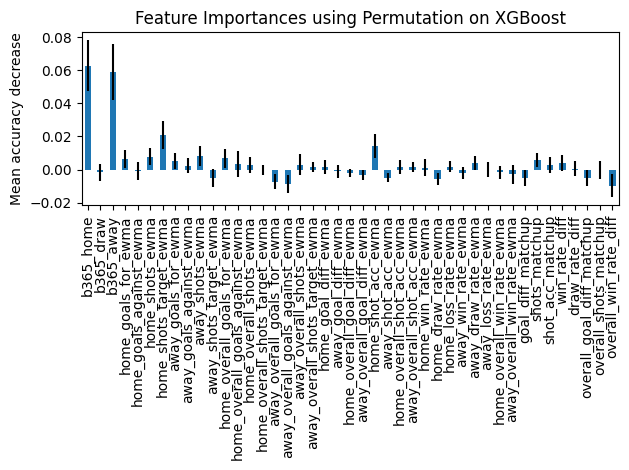

In [19]:
from sklearn.inspection import permutation_importance
result = permutation_importance(final_model, X_test, y_test, n_repeats=100, random_state=2)
import matplotlib.pyplot as plt

forest_importances = pd.Series(result.importances_mean, index=X_train.columns)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature Importances using Permutation on XGBoost")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [31]:
from sklearn.ensemble import RandomForestClassifier

# Optuna Objective for Random Forest
def objective_rf(trial, X_train, y_train, sample_weights, n_splits=n_splits):
    # Hyperparameters to optimize
    n_estimators = trial.suggest_int('n_estimators', 50, 300, step=50)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    
    cv_scores = []
    for fold_num, (train_idx, val_idx) in enumerate(TimeSeriesSplit(n_splits=n_splits).split(X_train), 1):
        X_cv_train = X_train.iloc[train_idx]
        X_cv_val = X_train.iloc[val_idx]
        y_cv_train = y_train.iloc[train_idx]
        y_cv_val = y_train.iloc[val_idx]
        weights_cv_train = sample_weights[train_idx]
        
        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            bootstrap=bootstrap,
            random_state=RANDOM_STATE,
            n_jobs=-1  # Parallel processing
        )
        
        model.fit(X_cv_train, y_cv_train, sample_weight=weights_cv_train)
        y_pred = model.predict(X_cv_val)
        fold_f1 = f1_score(y_cv_val, y_pred, average='macro')
        cv_scores.append(fold_f1)
        
        trial.report(fold_f1, fold_num)
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    mean_f1 = np.mean(cv_scores)
    return mean_f1


# Run Optuna optimization for Random Forest
print("\n" + "="*70)
print("RANDOM FOREST OPTIMIZATION WITH OPTUNA")
print("="*70 + "\n")

study_rf = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=2),
    study_name='random_forest_football_optuna'
)

n_trials_rf = 200
study_rf.optimize(
    lambda trial: objective_rf(trial, X_train, y_train, sample_weights, n_splits=3),
    n_trials=n_trials_rf,
    show_progress_bar=True
)

# Extract best parameters
best_params_rf = study_rf.best_params.copy()

print(f"\nBest F1 Score: {study_rf.best_value:.4f}")
print(f"Best Parameters: {best_params_rf}")

# Train final Random Forest
final_rf = RandomForestClassifier(
    n_estimators=best_params_rf['n_estimators'],
    max_depth=best_params_rf['max_depth'],
    min_samples_split=best_params_rf['min_samples_split'],
    min_samples_leaf=best_params_rf['min_samples_leaf'],
    max_features=best_params_rf['max_features'],
    bootstrap=best_params_rf['bootstrap'],
    random_state=RANDOM_STATE,
    n_jobs=-1
)

final_rf.fit(X_train, y_train, sample_weight=sample_weights)

# Predictions
y_pred_proba_rf = final_rf.predict_proba(X_test)
y_pred_rf = final_rf.predict(X_test)

# Metrics
test_accuracy_rf = accuracy_score(y_test, y_pred_rf)
test_f1_macro_rf = f1_score(y_test, y_pred_rf, average='macro')
test_f1_weighted_rf = f1_score(y_test, y_pred_rf, average='weighted')

print("\n" + "="*70)
print("RANDOM FOREST TEST RESULTS")
print("="*70)
print(f"Test Accuracy:       {test_accuracy_rf:.4f}")
print(f"Test F1 (Macro):     {test_f1_macro_rf:.4f}")
print(f"Test F1 (Weighted):  {test_f1_weighted_rf:.4f}")

print("\n" + "-" * 70)
print("CLASSIFICATION REPORT")
print("-" * 70)
print(classification_report(y_test, y_pred_rf, target_names=['Away Win', 'Draw', 'Home Win']))

# Profit calculation
bet_amount = 2
total_profit_rf = 0
for i in range(len(y_test)):
    true_result = y_test.iloc[i]
    pred_result = y_pred_rf[i]
    if pred_result == true_result:
        if pred_result == 0:
            odd = X_test.iloc[i]['b365_away']
        elif pred_result == 1:
            odd = X_test.iloc[i]['b365_draw']
        else:
            odd = X_test.iloc[i]['b365_home']
        profit = bet_amount * odd - bet_amount
        total_profit_rf += profit
    else:
        total_profit_rf -= bet_amount

total_wagered_rf = bet_amount * len(y_test)
profit_margin_rf = (total_profit_rf / total_wagered_rf) * 100

print("\n" + "="*70)
print("RANDOM FOREST PROFIT RESULTS")
print("="*70)
print(f"Profit:         €{total_profit_rf:.2f}")
print(f"Profit Margin:  {profit_margin_rf:.2f}%")
print(f"Total Wagered:  €{total_wagered_rf:.2f}")

[I 2025-11-04 23:23:27,347] A new study created in memory with name: random_forest_football_optuna



RANDOM FOREST OPTIMIZATION WITH OPTUNA



Best trial: 0. Best value: 0.44381:   0%|          | 1/200 [00:00<02:45,  1.20it/s]

[I 2025-11-04 23:23:28,184] Trial 0 finished with value: 0.4438097101694049 and parameters: {'n_estimators': 150, 'max_depth': 29, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.4438097101694049.


Best trial: 1. Best value: 0.453094:   1%|          | 2/200 [00:01<03:08,  1.05it/s]

[I 2025-11-04 23:23:29,215] Trial 1 finished with value: 0.4530936141746789 and parameters: {'n_estimators': 200, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.4530936141746789.


Best trial: 1. Best value: 0.453094:   2%|▏         | 3/200 [00:02<02:33,  1.28it/s]

[I 2025-11-04 23:23:29,792] Trial 2 finished with value: 0.4388817842789455 and parameters: {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.4530936141746789.


Best trial: 3. Best value: 0.453811:   2%|▏         | 4/200 [00:03<02:35,  1.26it/s]

[I 2025-11-04 23:23:30,607] Trial 3 finished with value: 0.4538108995161758 and parameters: {'n_estimators': 150, 'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 3 with value: 0.4538108995161758.


Best trial: 4. Best value: 0.462003:   2%|▎         | 5/200 [00:03<02:03,  1.58it/s]

[I 2025-11-04 23:23:30,952] Trial 4 finished with value: 0.4620030994852329 and parameters: {'n_estimators': 50, 'max_depth': 29, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 4 with value: 0.4620030994852329.


Best trial: 4. Best value: 0.462003:   3%|▎         | 6/200 [00:03<01:41,  1.92it/s]

[I 2025-11-04 23:23:31,257] Trial 5 finished with value: 0.44512455965298153 and parameters: {'n_estimators': 50, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'log2', 'bootstrap': False}. Best is trial 4 with value: 0.4620030994852329.


Best trial: 4. Best value: 0.462003:   4%|▎         | 7/200 [00:04<02:07,  1.51it/s]

[I 2025-11-04 23:23:32,209] Trial 6 finished with value: 0.45772866074193375 and parameters: {'n_estimators': 200, 'max_depth': 9, 'min_samples_split': 20, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 4 with value: 0.4620030994852329.


Best trial: 4. Best value: 0.462003:   4%|▍         | 8/200 [00:05<01:49,  1.76it/s]

[I 2025-11-04 23:23:32,580] Trial 7 finished with value: 0.4449758493637846 and parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 4 with value: 0.4620030994852329.


Best trial: 4. Best value: 0.462003:   4%|▍         | 9/200 [00:05<01:53,  1.68it/s]

[I 2025-11-04 23:23:33,220] Trial 8 finished with value: 0.4382245877304471 and parameters: {'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': True}. Best is trial 4 with value: 0.4620030994852329.


Best trial: 4. Best value: 0.462003:   5%|▌         | 10/200 [00:06<01:38,  1.94it/s]

[I 2025-11-04 23:23:33,571] Trial 9 finished with value: 0.4526990614365744 and parameters: {'n_estimators': 50, 'max_depth': 26, 'min_samples_split': 15, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 4 with value: 0.4620030994852329.


Best trial: 10. Best value: 0.469379:   6%|▌         | 11/200 [00:07<02:36,  1.21it/s]

[I 2025-11-04 23:23:35,105] Trial 10 finished with value: 0.4693789728041095 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 10 with value: 0.4693789728041095.


Best trial: 11. Best value: 0.470739:   6%|▌         | 12/200 [00:09<03:14,  1.03s/it]

[I 2025-11-04 23:23:36,606] Trial 11 finished with value: 0.47073869065127966 and parameters: {'n_estimators': 300, 'max_depth': 6, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 11 with value: 0.47073869065127966.


Best trial: 12. Best value: 0.471967:   6%|▋         | 13/200 [00:10<03:33,  1.14s/it]

[I 2025-11-04 23:23:38,002] Trial 12 finished with value: 0.47196746212287355 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 12 with value: 0.47196746212287355.


Best trial: 12. Best value: 0.471967:   7%|▋         | 14/200 [00:12<03:55,  1.26s/it]

[I 2025-11-04 23:23:39,545] Trial 13 finished with value: 0.47196746212287355 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 12 with value: 0.47196746212287355.


Best trial: 12. Best value: 0.471967:   8%|▊         | 15/200 [00:13<03:53,  1.26s/it]

[I 2025-11-04 23:23:40,803] Trial 14 finished with value: 0.45552248423615027 and parameters: {'n_estimators': 250, 'max_depth': 11, 'min_samples_split': 15, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True}. Best is trial 12 with value: 0.47196746212287355.


Best trial: 12. Best value: 0.471967:   8%|▊         | 16/200 [00:14<03:56,  1.28s/it]

[I 2025-11-04 23:23:42,140] Trial 15 pruned. 


Best trial: 12. Best value: 0.471967:   8%|▊         | 17/200 [00:16<03:52,  1.27s/it]

[I 2025-11-04 23:23:43,390] Trial 16 pruned. 


Best trial: 12. Best value: 0.471967:   9%|▉         | 18/200 [00:17<03:40,  1.21s/it]

[I 2025-11-04 23:23:44,463] Trial 17 pruned. 


Best trial: 12. Best value: 0.471967:  10%|▉         | 19/200 [00:18<03:39,  1.21s/it]

[I 2025-11-04 23:23:45,676] Trial 18 finished with value: 0.45134077656184673 and parameters: {'n_estimators': 250, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': True}. Best is trial 12 with value: 0.47196746212287355.


Best trial: 12. Best value: 0.471967:  10%|█         | 20/200 [00:19<03:48,  1.27s/it]

[I 2025-11-04 23:23:47,077] Trial 19 finished with value: 0.4703347363412232 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 12 with value: 0.47196746212287355.


Best trial: 12. Best value: 0.471967:  10%|█         | 21/200 [00:20<03:34,  1.20s/it]

[I 2025-11-04 23:23:48,107] Trial 20 pruned. 


Best trial: 12. Best value: 0.471967:  11%|█         | 22/200 [00:22<03:44,  1.26s/it]

[I 2025-11-04 23:23:49,509] Trial 21 finished with value: 0.47121742384840304 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 12 with value: 0.47196746212287355.


Best trial: 12. Best value: 0.471967:  12%|█▏        | 23/200 [00:23<03:56,  1.34s/it]

[I 2025-11-04 23:23:51,036] Trial 22 pruned. 


Best trial: 12. Best value: 0.471967:  12%|█▏        | 24/200 [00:24<03:53,  1.32s/it]

[I 2025-11-04 23:23:52,327] Trial 23 finished with value: 0.45718114404034277 and parameters: {'n_estimators': 250, 'max_depth': 10, 'min_samples_split': 18, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True}. Best is trial 12 with value: 0.47196746212287355.


Best trial: 24. Best value: 0.472668:  12%|█▎        | 25/200 [00:26<03:55,  1.34s/it]

[I 2025-11-04 23:23:53,717] Trial 24 finished with value: 0.4726676083082137 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 24 with value: 0.4726676083082137.


Best trial: 24. Best value: 0.472668:  13%|█▎        | 26/200 [00:27<03:45,  1.30s/it]

[I 2025-11-04 23:23:54,909] Trial 25 finished with value: 0.4624281944884208 and parameters: {'n_estimators': 250, 'max_depth': 7, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 24 with value: 0.4726676083082137.


Best trial: 24. Best value: 0.472668:  14%|█▎        | 27/200 [00:28<03:21,  1.16s/it]

[I 2025-11-04 23:23:55,752] Trial 26 pruned. 


Best trial: 24. Best value: 0.472668:  14%|█▍        | 28/200 [00:29<03:26,  1.20s/it]

[I 2025-11-04 23:23:57,042] Trial 27 pruned. 


Best trial: 24. Best value: 0.472668:  14%|█▍        | 29/200 [00:31<03:36,  1.27s/it]

[I 2025-11-04 23:23:58,466] Trial 28 pruned. 


Best trial: 29. Best value: 0.474079:  15%|█▌        | 30/200 [00:32<03:16,  1.15s/it]

[I 2025-11-04 23:23:59,357] Trial 29 finished with value: 0.4740786160611483 and parameters: {'n_estimators': 200, 'max_depth': 7, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': False}. Best is trial 29 with value: 0.4740786160611483.


Best trial: 29. Best value: 0.474079:  16%|█▌        | 31/200 [00:32<02:51,  1.02s/it]

[I 2025-11-04 23:24:00,051] Trial 30 pruned. 


Best trial: 29. Best value: 0.474079:  16%|█▌        | 32/200 [00:33<02:42,  1.03it/s]

[I 2025-11-04 23:24:00,897] Trial 31 finished with value: 0.47071491061322085 and parameters: {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 16, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': False}. Best is trial 29 with value: 0.4740786160611483.


Best trial: 29. Best value: 0.474079:  16%|█▋        | 33/200 [00:33<02:11,  1.27it/s]

[I 2025-11-04 23:24:01,272] Trial 32 pruned. 


Best trial: 29. Best value: 0.474079:  17%|█▋        | 34/200 [00:34<02:21,  1.17it/s]

[I 2025-11-04 23:24:02,271] Trial 33 finished with value: 0.4740786160611483 and parameters: {'n_estimators': 200, 'max_depth': 7, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': False}. Best is trial 29 with value: 0.4740786160611483.


Best trial: 29. Best value: 0.474079:  18%|█▊        | 35/200 [00:35<02:06,  1.30it/s]

[I 2025-11-04 23:24:02,846] Trial 34 pruned. 


Best trial: 29. Best value: 0.474079:  18%|█▊        | 36/200 [00:36<02:01,  1.34it/s]

[I 2025-11-04 23:24:03,527] Trial 35 finished with value: 0.4590892394222014 and parameters: {'n_estimators': 150, 'max_depth': 7, 'min_samples_split': 11, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 29 with value: 0.4740786160611483.


Best trial: 29. Best value: 0.474079:  18%|█▊        | 37/200 [00:37<02:08,  1.27it/s]

[I 2025-11-04 23:24:04,423] Trial 36 finished with value: 0.458959866074506 and parameters: {'n_estimators': 200, 'max_depth': 9, 'min_samples_split': 15, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': False}. Best is trial 29 with value: 0.4740786160611483.


Best trial: 29. Best value: 0.474079:  19%|█▉        | 38/200 [00:37<01:54,  1.41it/s]

[I 2025-11-04 23:24:04,944] Trial 37 pruned. 


Best trial: 29. Best value: 0.474079:  20%|█▉        | 39/200 [00:38<01:54,  1.41it/s]

[I 2025-11-04 23:24:05,661] Trial 38 pruned. 


Best trial: 29. Best value: 0.474079:  20%|██        | 40/200 [00:39<02:03,  1.29it/s]

[I 2025-11-04 23:24:06,574] Trial 39 pruned. 


Best trial: 29. Best value: 0.474079:  20%|██        | 41/200 [00:39<02:02,  1.29it/s]

[I 2025-11-04 23:24:07,347] Trial 40 pruned. 


Best trial: 29. Best value: 0.474079:  21%|██        | 42/200 [00:41<02:16,  1.16it/s]

[I 2025-11-04 23:24:08,431] Trial 41 pruned. 


Best trial: 29. Best value: 0.474079:  22%|██▏       | 43/200 [00:42<02:36,  1.00it/s]

[I 2025-11-04 23:24:09,733] Trial 42 finished with value: 0.4691625318993336 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 18, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}. Best is trial 29 with value: 0.4740786160611483.


Best trial: 29. Best value: 0.474079:  22%|██▏       | 44/200 [00:43<02:58,  1.14s/it]

[I 2025-11-04 23:24:11,222] Trial 43 pruned. 


Best trial: 29. Best value: 0.474079:  22%|██▎       | 45/200 [00:45<03:09,  1.22s/it]

[I 2025-11-04 23:24:12,632] Trial 44 pruned. 


Best trial: 29. Best value: 0.474079:  23%|██▎       | 46/200 [00:47<03:37,  1.41s/it]

[I 2025-11-04 23:24:14,491] Trial 45 pruned. 


Best trial: 29. Best value: 0.474079:  24%|██▎       | 47/200 [00:47<03:08,  1.23s/it]

[I 2025-11-04 23:24:15,297] Trial 46 pruned. 


Best trial: 29. Best value: 0.474079:  24%|██▍       | 48/200 [00:48<02:46,  1.09s/it]

[I 2025-11-04 23:24:16,069] Trial 47 pruned. 


Best trial: 29. Best value: 0.474079:  24%|██▍       | 49/200 [00:50<03:09,  1.25s/it]

[I 2025-11-04 23:24:17,702] Trial 48 pruned. 


Best trial: 29. Best value: 0.474079:  25%|██▌       | 50/200 [00:51<03:02,  1.22s/it]

[I 2025-11-04 23:24:18,826] Trial 49 pruned. 


Best trial: 29. Best value: 0.474079:  26%|██▌       | 51/200 [00:52<02:43,  1.09s/it]

[I 2025-11-04 23:24:19,638] Trial 50 finished with value: 0.4665230588872573 and parameters: {'n_estimators': 150, 'max_depth': 19, 'min_samples_split': 11, 'min_samples_leaf': 10, 'max_features': 'log2', 'bootstrap': True}. Best is trial 29 with value: 0.4740786160611483.


Best trial: 29. Best value: 0.474079:  26%|██▌       | 52/200 [00:53<02:56,  1.19s/it]

[I 2025-11-04 23:24:21,064] Trial 51 finished with value: 0.47121742384840304 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 29 with value: 0.4740786160611483.


Best trial: 29. Best value: 0.474079:  26%|██▋       | 53/200 [00:55<03:05,  1.26s/it]

[I 2025-11-04 23:24:22,492] Trial 52 pruned. 


Best trial: 29. Best value: 0.474079:  27%|██▋       | 54/200 [00:56<03:18,  1.36s/it]

[I 2025-11-04 23:24:24,068] Trial 53 finished with value: 0.4722897870519553 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 19, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 29 with value: 0.4740786160611483.


Best trial: 29. Best value: 0.474079:  28%|██▊       | 55/200 [00:58<03:21,  1.39s/it]

[I 2025-11-04 23:24:25,540] Trial 54 pruned. 


Best trial: 55. Best value: 0.475176:  28%|██▊       | 56/200 [00:59<03:09,  1.32s/it]

[I 2025-11-04 23:24:26,683] Trial 55 finished with value: 0.47517642442348845 and parameters: {'n_estimators': 250, 'max_depth': 5, 'min_samples_split': 18, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': True}. Best is trial 55 with value: 0.47517642442348845.


Best trial: 55. Best value: 0.475176:  28%|██▊       | 57/200 [01:00<02:53,  1.22s/it]

[I 2025-11-04 23:24:27,658] Trial 56 pruned. 


Best trial: 55. Best value: 0.475176:  29%|██▉       | 58/200 [01:01<02:50,  1.20s/it]

[I 2025-11-04 23:24:28,834] Trial 57 pruned. 


Best trial: 55. Best value: 0.475176:  30%|██▉       | 59/200 [01:02<02:50,  1.21s/it]

[I 2025-11-04 23:24:30,065] Trial 58 pruned. 


Best trial: 55. Best value: 0.475176:  30%|███       | 60/200 [01:03<02:38,  1.13s/it]

[I 2025-11-04 23:24:31,013] Trial 59 pruned. 


Best trial: 55. Best value: 0.475176:  30%|███       | 61/200 [01:04<02:24,  1.04s/it]

[I 2025-11-04 23:24:31,836] Trial 60 pruned. 


Best trial: 55. Best value: 0.475176:  31%|███       | 62/200 [01:05<02:37,  1.14s/it]

[I 2025-11-04 23:24:33,216] Trial 61 finished with value: 0.47114013062336674 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 18, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 55 with value: 0.47517642442348845.


Best trial: 55. Best value: 0.475176:  32%|███▏      | 63/200 [01:07<02:54,  1.27s/it]

[I 2025-11-04 23:24:34,795] Trial 62 finished with value: 0.4571733957942277 and parameters: {'n_estimators': 300, 'max_depth': 6, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 55 with value: 0.47517642442348845.


Best trial: 55. Best value: 0.475176:  32%|███▏      | 64/200 [01:08<03:02,  1.35s/it]

[I 2025-11-04 23:24:36,308] Trial 63 pruned. 


Best trial: 55. Best value: 0.475176:  32%|███▎      | 65/200 [01:10<03:06,  1.38s/it]

[I 2025-11-04 23:24:37,776] Trial 64 finished with value: 0.47451258606586827 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 55 with value: 0.47517642442348845.


Best trial: 55. Best value: 0.475176:  33%|███▎      | 66/200 [01:11<03:05,  1.38s/it]

[I 2025-11-04 23:24:39,158] Trial 65 pruned. 


Best trial: 55. Best value: 0.475176:  34%|███▎      | 67/200 [01:13<03:10,  1.43s/it]

[I 2025-11-04 23:24:40,696] Trial 66 finished with value: 0.4715487195194274 and parameters: {'n_estimators': 300, 'max_depth': 6, 'min_samples_split': 18, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True}. Best is trial 55 with value: 0.47517642442348845.


Best trial: 55. Best value: 0.475176:  34%|███▍      | 68/200 [01:14<02:48,  1.28s/it]

[I 2025-11-04 23:24:41,616] Trial 67 pruned. 


Best trial: 55. Best value: 0.475176:  34%|███▍      | 69/200 [01:15<03:01,  1.38s/it]

[I 2025-11-04 23:24:43,256] Trial 68 pruned. 


Best trial: 55. Best value: 0.475176:  35%|███▌      | 70/200 [01:17<02:50,  1.31s/it]

[I 2025-11-04 23:24:44,409] Trial 69 finished with value: 0.4664075012184183 and parameters: {'n_estimators': 250, 'max_depth': 9, 'min_samples_split': 19, 'min_samples_leaf': 7, 'max_features': 'log2', 'bootstrap': False}. Best is trial 55 with value: 0.47517642442348845.


Best trial: 55. Best value: 0.475176:  36%|███▌      | 71/200 [01:18<02:55,  1.36s/it]

[I 2025-11-04 23:24:45,883] Trial 70 pruned. 


Best trial: 55. Best value: 0.475176:  36%|███▌      | 72/200 [01:19<02:58,  1.39s/it]

[I 2025-11-04 23:24:47,345] Trial 71 finished with value: 0.47196746212287355 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 55 with value: 0.47517642442348845.


Best trial: 55. Best value: 0.475176:  36%|███▋      | 73/200 [01:21<03:00,  1.42s/it]

[I 2025-11-04 23:24:48,834] Trial 72 pruned. 


Best trial: 55. Best value: 0.475176:  37%|███▋      | 74/200 [01:22<02:58,  1.42s/it]

[I 2025-11-04 23:24:50,232] Trial 73 finished with value: 0.47251268329286217 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 55 with value: 0.47517642442348845.


Best trial: 55. Best value: 0.475176:  38%|███▊      | 75/200 [01:24<03:05,  1.49s/it]

[I 2025-11-04 23:24:51,882] Trial 74 pruned. 


Best trial: 55. Best value: 0.475176:  38%|███▊      | 76/200 [01:26<03:12,  1.55s/it]

[I 2025-11-04 23:24:53,583] Trial 75 pruned. 


Best trial: 55. Best value: 0.475176:  38%|███▊      | 77/200 [01:27<02:54,  1.42s/it]

[I 2025-11-04 23:24:54,710] Trial 76 pruned. 


Best trial: 55. Best value: 0.475176:  39%|███▉      | 78/200 [01:29<03:02,  1.50s/it]

[I 2025-11-04 23:24:56,379] Trial 77 pruned. 


Best trial: 55. Best value: 0.475176:  40%|███▉      | 79/200 [01:29<02:39,  1.32s/it]

[I 2025-11-04 23:24:57,287] Trial 78 pruned. 


Best trial: 55. Best value: 0.475176:  40%|████      | 80/200 [01:31<02:36,  1.30s/it]

[I 2025-11-04 23:24:58,549] Trial 79 pruned. 


Best trial: 55. Best value: 0.475176:  40%|████      | 81/200 [01:32<02:41,  1.35s/it]

[I 2025-11-04 23:25:00,019] Trial 80 pruned. 


Best trial: 55. Best value: 0.475176:  41%|████      | 82/200 [01:34<02:42,  1.37s/it]

[I 2025-11-04 23:25:01,441] Trial 81 finished with value: 0.4735125038255397 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 55 with value: 0.47517642442348845.


Best trial: 55. Best value: 0.475176:  42%|████▏     | 83/200 [01:35<02:42,  1.39s/it]

[I 2025-11-04 23:25:02,875] Trial 82 finished with value: 0.4745491952028494 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 55 with value: 0.47517642442348845.


Best trial: 55. Best value: 0.475176:  42%|████▏     | 84/200 [01:36<02:41,  1.40s/it]

[I 2025-11-04 23:25:04,280] Trial 83 pruned. 


Best trial: 55. Best value: 0.475176:  42%|████▎     | 85/200 [01:38<02:39,  1.39s/it]

[I 2025-11-04 23:25:05,655] Trial 84 finished with value: 0.4726676083082137 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 55 with value: 0.47517642442348845.


Best trial: 55. Best value: 0.475176:  43%|████▎     | 86/200 [01:39<02:40,  1.41s/it]

[I 2025-11-04 23:25:07,102] Trial 85 pruned. 


Best trial: 55. Best value: 0.475176:  44%|████▎     | 87/200 [01:41<02:39,  1.41s/it]

[I 2025-11-04 23:25:08,524] Trial 86 pruned. 


Best trial: 55. Best value: 0.475176:  44%|████▍     | 88/200 [01:41<02:07,  1.14s/it]

[I 2025-11-04 23:25:09,029] Trial 87 pruned. 


Best trial: 55. Best value: 0.475176:  44%|████▍     | 89/200 [01:42<02:05,  1.13s/it]

[I 2025-11-04 23:25:10,143] Trial 88 pruned. 


Best trial: 55. Best value: 0.475176:  45%|████▌     | 90/200 [01:43<01:56,  1.06s/it]

[I 2025-11-04 23:25:11,027] Trial 89 pruned. 


Best trial: 55. Best value: 0.475176:  46%|████▌     | 91/200 [01:45<02:12,  1.22s/it]

[I 2025-11-04 23:25:12,618] Trial 90 pruned. 


Best trial: 55. Best value: 0.475176:  46%|████▌     | 92/200 [01:46<02:16,  1.26s/it]

[I 2025-11-04 23:25:13,985] Trial 91 finished with value: 0.47394146547319504 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 55 with value: 0.47517642442348845.


Best trial: 55. Best value: 0.475176:  46%|████▋     | 93/200 [01:48<02:31,  1.41s/it]

[I 2025-11-04 23:25:15,761] Trial 92 pruned. 


Best trial: 55. Best value: 0.475176:  47%|████▋     | 94/200 [01:49<02:34,  1.45s/it]

[I 2025-11-04 23:25:17,309] Trial 93 pruned. 


Best trial: 55. Best value: 0.475176:  48%|████▊     | 95/200 [01:51<02:31,  1.45s/it]

[I 2025-11-04 23:25:18,738] Trial 94 pruned. 


Best trial: 55. Best value: 0.475176:  48%|████▊     | 96/200 [01:52<02:27,  1.42s/it]

[I 2025-11-04 23:25:20,097] Trial 95 finished with value: 0.4735125038255397 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 55 with value: 0.47517642442348845.


Best trial: 55. Best value: 0.475176:  48%|████▊     | 97/200 [01:53<02:19,  1.35s/it]

[I 2025-11-04 23:25:21,296] Trial 96 pruned. 


Best trial: 55. Best value: 0.475176:  49%|████▉     | 98/200 [01:54<02:05,  1.23s/it]

[I 2025-11-04 23:25:22,242] Trial 97 pruned. 


Best trial: 55. Best value: 0.475176:  50%|████▉     | 99/200 [01:55<01:48,  1.07s/it]

[I 2025-11-04 23:25:22,942] Trial 98 pruned. 


Best trial: 55. Best value: 0.475176:  50%|█████     | 100/200 [01:56<01:50,  1.10s/it]

[I 2025-11-04 23:25:24,111] Trial 99 pruned. 


Best trial: 55. Best value: 0.475176:  50%|█████     | 101/200 [01:58<02:02,  1.24s/it]

[I 2025-11-04 23:25:25,674] Trial 100 pruned. 


Best trial: 55. Best value: 0.475176:  51%|█████     | 102/200 [01:59<02:08,  1.31s/it]

[I 2025-11-04 23:25:27,164] Trial 101 pruned. 


Best trial: 55. Best value: 0.475176:  52%|█████▏    | 103/200 [02:01<02:10,  1.34s/it]

[I 2025-11-04 23:25:28,572] Trial 102 finished with value: 0.47394146547319504 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 55 with value: 0.47517642442348845.


Best trial: 55. Best value: 0.475176:  52%|█████▏    | 104/200 [02:02<02:11,  1.37s/it]

[I 2025-11-04 23:25:30,018] Trial 103 finished with value: 0.4595852481787068 and parameters: {'n_estimators': 300, 'max_depth': 6, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 55 with value: 0.47517642442348845.


Best trial: 55. Best value: 0.475176:  52%|█████▎    | 105/200 [02:04<02:12,  1.39s/it]

[I 2025-11-04 23:25:31,455] Trial 104 finished with value: 0.47394146547319504 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 55 with value: 0.47517642442348845.


Best trial: 55. Best value: 0.475176:  53%|█████▎    | 106/200 [02:05<01:59,  1.27s/it]

[I 2025-11-04 23:25:32,442] Trial 105 pruned. 


Best trial: 55. Best value: 0.475176:  54%|█████▎    | 107/200 [02:06<02:02,  1.31s/it]

[I 2025-11-04 23:25:33,854] Trial 106 pruned. 


Best trial: 55. Best value: 0.475176:  54%|█████▍    | 108/200 [02:07<01:54,  1.24s/it]

[I 2025-11-04 23:25:34,927] Trial 107 pruned. 


Best trial: 55. Best value: 0.475176:  55%|█████▍    | 109/200 [02:08<01:45,  1.16s/it]

[I 2025-11-04 23:25:35,907] Trial 108 pruned. 


Best trial: 55. Best value: 0.475176:  55%|█████▌    | 110/200 [02:09<01:51,  1.24s/it]

[I 2025-11-04 23:25:37,344] Trial 109 finished with value: 0.47394146547319504 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 55 with value: 0.47517642442348845.


Best trial: 55. Best value: 0.475176:  56%|█████▌    | 111/200 [02:11<01:57,  1.32s/it]

[I 2025-11-04 23:25:38,833] Trial 110 finished with value: 0.47196746212287355 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 55 with value: 0.47517642442348845.


Best trial: 55. Best value: 0.475176:  56%|█████▌    | 112/200 [02:13<02:01,  1.38s/it]

[I 2025-11-04 23:25:40,356] Trial 111 finished with value: 0.47394146547319504 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 55 with value: 0.47517642442348845.


Best trial: 55. Best value: 0.475176:  56%|█████▋    | 113/200 [02:14<02:05,  1.44s/it]

[I 2025-11-04 23:25:41,931] Trial 112 finished with value: 0.4735125038255397 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 55 with value: 0.47517642442348845.


Best trial: 55. Best value: 0.475176:  57%|█████▋    | 114/200 [02:16<02:04,  1.45s/it]

[I 2025-11-04 23:25:43,419] Trial 113 pruned. 


Best trial: 55. Best value: 0.475176:  57%|█████▊    | 115/200 [02:17<02:05,  1.48s/it]

[I 2025-11-04 23:25:44,946] Trial 114 pruned. 


Best trial: 55. Best value: 0.475176:  58%|█████▊    | 116/200 [02:19<02:04,  1.48s/it]

[I 2025-11-04 23:25:46,445] Trial 115 finished with value: 0.4720291756533544 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 55 with value: 0.47517642442348845.


Best trial: 55. Best value: 0.475176:  58%|█████▊    | 117/200 [02:20<02:02,  1.48s/it]

[I 2025-11-04 23:25:47,909] Trial 116 pruned. 


Best trial: 55. Best value: 0.475176:  59%|█████▉    | 118/200 [02:21<01:52,  1.37s/it]

[I 2025-11-04 23:25:49,041] Trial 117 pruned. 


Best trial: 55. Best value: 0.475176:  60%|█████▉    | 119/200 [02:23<01:51,  1.37s/it]

[I 2025-11-04 23:25:50,416] Trial 118 finished with value: 0.4735125038255397 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 55 with value: 0.47517642442348845.


Best trial: 55. Best value: 0.475176:  60%|██████    | 120/200 [02:24<01:41,  1.26s/it]

[I 2025-11-04 23:25:51,422] Trial 119 pruned. 


Best trial: 55. Best value: 0.475176:  60%|██████    | 121/200 [02:25<01:36,  1.22s/it]

[I 2025-11-04 23:25:52,523] Trial 120 pruned. 


Best trial: 55. Best value: 0.475176:  61%|██████    | 122/200 [02:26<01:41,  1.30s/it]

[I 2025-11-04 23:25:54,012] Trial 121 finished with value: 0.4735125038255397 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 55 with value: 0.47517642442348845.


Best trial: 55. Best value: 0.475176:  62%|██████▏   | 123/200 [02:28<01:42,  1.33s/it]

[I 2025-11-04 23:25:55,413] Trial 122 finished with value: 0.4735125038255397 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 55 with value: 0.47517642442348845.


Best trial: 55. Best value: 0.475176:  62%|██████▏   | 124/200 [02:29<01:44,  1.37s/it]

[I 2025-11-04 23:25:56,875] Trial 123 finished with value: 0.47394146547319504 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 55 with value: 0.47517642442348845.


Best trial: 55. Best value: 0.475176:  62%|██████▎   | 125/200 [02:30<01:42,  1.37s/it]

[I 2025-11-04 23:25:58,261] Trial 124 pruned. 


Best trial: 55. Best value: 0.475176:  63%|██████▎   | 126/200 [02:32<01:42,  1.39s/it]

[I 2025-11-04 23:25:59,672] Trial 125 pruned. 


Best trial: 55. Best value: 0.475176:  64%|██████▎   | 127/200 [02:33<01:43,  1.42s/it]

[I 2025-11-04 23:26:01,172] Trial 126 pruned. 


Best trial: 55. Best value: 0.475176:  64%|██████▍   | 128/200 [02:34<01:34,  1.31s/it]

[I 2025-11-04 23:26:02,238] Trial 127 pruned. 


Best trial: 55. Best value: 0.475176:  64%|██████▍   | 129/200 [02:36<01:42,  1.44s/it]

[I 2025-11-04 23:26:03,977] Trial 128 finished with value: 0.4735125038255397 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 55 with value: 0.47517642442348845.


Best trial: 55. Best value: 0.475176:  65%|██████▌   | 130/200 [02:38<01:46,  1.52s/it]

[I 2025-11-04 23:26:05,691] Trial 129 pruned. 


Best trial: 55. Best value: 0.475176:  66%|██████▌   | 131/200 [02:39<01:43,  1.50s/it]

[I 2025-11-04 23:26:07,136] Trial 130 pruned. 


Best trial: 55. Best value: 0.475176:  66%|██████▌   | 132/200 [02:41<01:40,  1.47s/it]

[I 2025-11-04 23:26:08,545] Trial 131 finished with value: 0.4735125038255397 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 55 with value: 0.47517642442348845.


Best trial: 55. Best value: 0.475176:  66%|██████▋   | 133/200 [02:42<01:37,  1.46s/it]

[I 2025-11-04 23:26:09,973] Trial 132 finished with value: 0.4735125038255397 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 55 with value: 0.47517642442348845.


Best trial: 55. Best value: 0.475176:  67%|██████▋   | 134/200 [02:44<01:34,  1.44s/it]

[I 2025-11-04 23:26:11,364] Trial 133 finished with value: 0.47394146547319504 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 55 with value: 0.47517642442348845.


Best trial: 55. Best value: 0.475176:  68%|██████▊   | 135/200 [02:45<01:33,  1.44s/it]

[I 2025-11-04 23:26:12,795] Trial 134 finished with value: 0.4673378391063913 and parameters: {'n_estimators': 300, 'max_depth': 6, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 55 with value: 0.47517642442348845.


Best trial: 55. Best value: 0.475176:  68%|██████▊   | 136/200 [02:47<01:36,  1.51s/it]

[I 2025-11-04 23:26:14,461] Trial 135 pruned. 


Best trial: 55. Best value: 0.475176:  68%|██████▊   | 137/200 [02:48<01:27,  1.38s/it]

[I 2025-11-04 23:26:15,545] Trial 136 finished with value: 0.47509096045541116 and parameters: {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 55 with value: 0.47517642442348845.


Best trial: 55. Best value: 0.475176:  69%|██████▉   | 138/200 [02:49<01:21,  1.32s/it]

[I 2025-11-04 23:26:16,728] Trial 137 finished with value: 0.47490729228835193 and parameters: {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 55 with value: 0.47517642442348845.


Best trial: 55. Best value: 0.475176:  70%|██████▉   | 139/200 [02:50<01:14,  1.22s/it]

[I 2025-11-04 23:26:17,704] Trial 138 finished with value: 0.4695661202451152 and parameters: {'n_estimators': 200, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 55 with value: 0.47517642442348845.


Best trial: 55. Best value: 0.475176:  70%|███████   | 140/200 [02:51<01:03,  1.07s/it]

[I 2025-11-04 23:26:18,413] Trial 139 pruned. 


Best trial: 55. Best value: 0.475176:  70%|███████   | 141/200 [02:51<00:58,  1.00it/s]

[I 2025-11-04 23:26:19,261] Trial 140 pruned. 


Best trial: 55. Best value: 0.475176:  71%|███████   | 142/200 [02:52<00:56,  1.03it/s]

[I 2025-11-04 23:26:20,170] Trial 141 finished with value: 0.47509096045541116 and parameters: {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 55 with value: 0.47517642442348845.


Best trial: 55. Best value: 0.475176:  72%|███████▏  | 143/200 [02:53<00:49,  1.15it/s]

[I 2025-11-04 23:26:20,811] Trial 142 pruned. 


Best trial: 143. Best value: 0.476451:  72%|███████▏  | 144/200 [02:54<00:50,  1.12it/s]

[I 2025-11-04 23:26:21,762] Trial 143 finished with value: 0.47645068187950024 and parameters: {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True}. Best is trial 143 with value: 0.47645068187950024.


Best trial: 143. Best value: 0.476451:  72%|███████▎  | 145/200 [02:55<00:58,  1.07s/it]

[I 2025-11-04 23:26:23,243] Trial 144 finished with value: 0.4684801770993842 and parameters: {'n_estimators': 200, 'max_depth': 6, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True}. Best is trial 143 with value: 0.47645068187950024.


Best trial: 143. Best value: 0.476451:  73%|███████▎  | 146/200 [02:56<00:50,  1.07it/s]

[I 2025-11-04 23:26:23,869] Trial 145 pruned. 


Best trial: 143. Best value: 0.476451:  74%|███████▎  | 147/200 [02:57<00:49,  1.08it/s]

[I 2025-11-04 23:26:24,781] Trial 146 finished with value: 0.4758364423142367 and parameters: {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 143 with value: 0.47645068187950024.


Best trial: 143. Best value: 0.476451:  74%|███████▍  | 148/200 [02:58<00:49,  1.05it/s]

[I 2025-11-04 23:26:25,777] Trial 147 pruned. 


Best trial: 143. Best value: 0.476451:  74%|███████▍  | 149/200 [02:59<00:48,  1.05it/s]

[I 2025-11-04 23:26:26,725] Trial 148 finished with value: 0.4758364423142367 and parameters: {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 143 with value: 0.47645068187950024.


Best trial: 143. Best value: 0.476451:  75%|███████▌  | 150/200 [03:00<00:47,  1.06it/s]

[I 2025-11-04 23:26:27,659] Trial 149 pruned. 


Best trial: 143. Best value: 0.476451:  76%|███████▌  | 151/200 [03:01<00:45,  1.09it/s]

[I 2025-11-04 23:26:28,518] Trial 150 pruned. 


Best trial: 143. Best value: 0.476451:  76%|███████▌  | 152/200 [03:02<00:44,  1.08it/s]

[I 2025-11-04 23:26:29,470] Trial 151 finished with value: 0.4758364423142367 and parameters: {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 143 with value: 0.47645068187950024.


Best trial: 143. Best value: 0.476451:  76%|███████▋  | 153/200 [03:03<00:43,  1.08it/s]

[I 2025-11-04 23:26:30,390] Trial 152 finished with value: 0.47490729228835193 and parameters: {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 143 with value: 0.47645068187950024.


Best trial: 143. Best value: 0.476451:  77%|███████▋  | 154/200 [03:03<00:42,  1.08it/s]

[I 2025-11-04 23:26:31,309] Trial 153 finished with value: 0.47490729228835193 and parameters: {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 143 with value: 0.47645068187950024.


Best trial: 143. Best value: 0.476451:  78%|███████▊  | 155/200 [03:04<00:41,  1.07it/s]

[I 2025-11-04 23:26:32,263] Trial 154 finished with value: 0.47490729228835193 and parameters: {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 143 with value: 0.47645068187950024.


Best trial: 143. Best value: 0.476451:  78%|███████▊  | 156/200 [03:05<00:37,  1.18it/s]

[I 2025-11-04 23:26:32,909] Trial 155 pruned. 


Best trial: 143. Best value: 0.476451:  78%|███████▊  | 157/200 [03:06<00:37,  1.13it/s]

[I 2025-11-04 23:26:33,872] Trial 156 pruned. 


Best trial: 143. Best value: 0.476451:  79%|███████▉  | 158/200 [03:07<00:39,  1.07it/s]

[I 2025-11-04 23:26:34,924] Trial 157 finished with value: 0.4725716071138379 and parameters: {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 143 with value: 0.47645068187950024.


Best trial: 143. Best value: 0.476451:  80%|███████▉  | 159/200 [03:08<00:38,  1.06it/s]

[I 2025-11-04 23:26:35,906] Trial 158 pruned. 


Best trial: 143. Best value: 0.476451:  80%|████████  | 160/200 [03:09<00:36,  1.08it/s]

[I 2025-11-04 23:26:36,780] Trial 159 finished with value: 0.4746006844396831 and parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 143 with value: 0.47645068187950024.


Best trial: 143. Best value: 0.476451:  80%|████████  | 161/200 [03:10<00:34,  1.12it/s]

[I 2025-11-04 23:26:37,583] Trial 160 pruned. 


Best trial: 143. Best value: 0.476451:  81%|████████  | 162/200 [03:11<00:33,  1.14it/s]

[I 2025-11-04 23:26:38,429] Trial 161 finished with value: 0.4746006844396831 and parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 143 with value: 0.47645068187950024.


Best trial: 143. Best value: 0.476451:  82%|████████▏ | 163/200 [03:11<00:31,  1.19it/s]

[I 2025-11-04 23:26:39,186] Trial 162 finished with value: 0.4746006844396831 and parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 143 with value: 0.47645068187950024.


Best trial: 163. Best value: 0.479131:  82%|████████▏ | 164/200 [03:12<00:29,  1.23it/s]

[I 2025-11-04 23:26:39,937] Trial 163 finished with value: 0.47913140266038107 and parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 163 with value: 0.47913140266038107.


Best trial: 163. Best value: 0.479131:  82%|████████▎ | 165/200 [03:13<00:27,  1.27it/s]

[I 2025-11-04 23:26:40,664] Trial 164 finished with value: 0.47913140266038107 and parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 163 with value: 0.47913140266038107.


Best trial: 163. Best value: 0.479131:  83%|████████▎ | 166/200 [03:14<00:27,  1.26it/s]

[I 2025-11-04 23:26:41,481] Trial 165 finished with value: 0.47913140266038107 and parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 163 with value: 0.47913140266038107.


Best trial: 166. Best value: 0.483294:  84%|████████▎ | 167/200 [03:14<00:25,  1.28it/s]

[I 2025-11-04 23:26:42,221] Trial 166 finished with value: 0.4832943958009282 and parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 166 with value: 0.4832943958009282.


Best trial: 166. Best value: 0.483294:  84%|████████▍ | 168/200 [03:15<00:22,  1.45it/s]

[I 2025-11-04 23:26:42,702] Trial 167 pruned. 


Best trial: 166. Best value: 0.483294:  84%|████████▍ | 169/200 [03:16<00:22,  1.36it/s]

[I 2025-11-04 23:26:43,544] Trial 168 finished with value: 0.47913140266038107 and parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 166 with value: 0.4832943958009282.


Best trial: 166. Best value: 0.483294:  85%|████████▌ | 170/200 [03:16<00:22,  1.36it/s]

[I 2025-11-04 23:26:44,288] Trial 169 finished with value: 0.47913140266038107 and parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 166 with value: 0.4832943958009282.


Best trial: 166. Best value: 0.483294:  86%|████████▌ | 171/200 [03:17<00:21,  1.35it/s]

[I 2025-11-04 23:26:45,029] Trial 170 pruned. 


Best trial: 166. Best value: 0.483294:  86%|████████▌ | 172/200 [03:18<00:20,  1.34it/s]

[I 2025-11-04 23:26:45,789] Trial 171 finished with value: 0.47913140266038107 and parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 166 with value: 0.4832943958009282.


Best trial: 166. Best value: 0.483294:  86%|████████▋ | 173/200 [03:19<00:20,  1.34it/s]

[I 2025-11-04 23:26:46,535] Trial 172 finished with value: 0.47913140266038107 and parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 166 with value: 0.4832943958009282.


Best trial: 166. Best value: 0.483294:  87%|████████▋ | 174/200 [03:19<00:19,  1.34it/s]

[I 2025-11-04 23:26:47,275] Trial 173 finished with value: 0.47913140266038107 and parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 166 with value: 0.4832943958009282.


Best trial: 166. Best value: 0.483294:  88%|████████▊ | 175/200 [03:20<00:16,  1.51it/s]

[I 2025-11-04 23:26:47,750] Trial 174 pruned. 


Best trial: 166. Best value: 0.483294:  88%|████████▊ | 176/200 [03:21<00:17,  1.41it/s]

[I 2025-11-04 23:26:48,568] Trial 175 finished with value: 0.4832943958009282 and parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 166 with value: 0.4832943958009282.


Best trial: 166. Best value: 0.483294:  88%|████████▊ | 177/200 [03:21<00:16,  1.38it/s]

[I 2025-11-04 23:26:49,331] Trial 176 finished with value: 0.47049914453529595 and parameters: {'n_estimators': 150, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 166 with value: 0.4832943958009282.


Best trial: 166. Best value: 0.483294:  89%|████████▉ | 178/200 [03:22<00:16,  1.37it/s]

[I 2025-11-04 23:26:50,065] Trial 177 finished with value: 0.47913140266038107 and parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 166 with value: 0.4832943958009282.


Best trial: 166. Best value: 0.483294:  90%|████████▉ | 179/200 [03:23<00:16,  1.30it/s]

[I 2025-11-04 23:26:50,926] Trial 178 finished with value: 0.47913140266038107 and parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 166 with value: 0.4832943958009282.


Best trial: 166. Best value: 0.483294:  90%|█████████ | 180/200 [03:24<00:13,  1.45it/s]

[I 2025-11-04 23:26:51,433] Trial 179 pruned. 


Best trial: 166. Best value: 0.483294:  90%|█████████ | 181/200 [03:24<00:13,  1.38it/s]

[I 2025-11-04 23:26:52,237] Trial 180 finished with value: 0.47862521308171607 and parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 166 with value: 0.4832943958009282.


Best trial: 166. Best value: 0.483294:  91%|█████████ | 182/200 [03:25<00:13,  1.30it/s]

[I 2025-11-04 23:26:53,112] Trial 181 finished with value: 0.47862521308171607 and parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 166 with value: 0.4832943958009282.


Best trial: 166. Best value: 0.483294:  92%|█████████▏| 183/200 [03:26<00:13,  1.24it/s]

[I 2025-11-04 23:26:54,002] Trial 182 finished with value: 0.47862521308171607 and parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 166 with value: 0.4832943958009282.


Best trial: 166. Best value: 0.483294:  92%|█████████▏| 184/200 [03:27<00:13,  1.23it/s]

[I 2025-11-04 23:26:54,840] Trial 183 finished with value: 0.47862521308171607 and parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 166 with value: 0.4832943958009282.


Best trial: 166. Best value: 0.483294:  92%|█████████▎| 185/200 [03:28<00:12,  1.24it/s]

[I 2025-11-04 23:26:55,617] Trial 184 finished with value: 0.4684130460168703 and parameters: {'n_estimators': 150, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 166 with value: 0.4832943958009282.


Best trial: 166. Best value: 0.483294:  93%|█████████▎| 186/200 [03:29<00:11,  1.27it/s]

[I 2025-11-04 23:26:56,360] Trial 185 finished with value: 0.4790997857128283 and parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 166 with value: 0.4832943958009282.


Best trial: 166. Best value: 0.483294:  94%|█████████▎| 187/200 [03:29<00:10,  1.29it/s]

[I 2025-11-04 23:26:57,116] Trial 186 pruned. 


Best trial: 166. Best value: 0.483294:  94%|█████████▍| 188/200 [03:30<00:09,  1.28it/s]

[I 2025-11-04 23:26:57,919] Trial 187 finished with value: 0.4790997857128283 and parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 166 with value: 0.4832943958009282.


Best trial: 166. Best value: 0.483294:  94%|█████████▍| 189/200 [03:31<00:08,  1.28it/s]

[I 2025-11-04 23:26:58,687] Trial 188 finished with value: 0.4790997857128283 and parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 166 with value: 0.4832943958009282.


Best trial: 166. Best value: 0.483294:  95%|█████████▌| 190/200 [03:32<00:07,  1.27it/s]

[I 2025-11-04 23:26:59,488] Trial 189 pruned. 


Best trial: 166. Best value: 0.483294:  96%|█████████▌| 191/200 [03:32<00:07,  1.29it/s]

[I 2025-11-04 23:27:00,245] Trial 190 finished with value: 0.4790997857128283 and parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 166 with value: 0.4832943958009282.


Best trial: 166. Best value: 0.483294:  96%|█████████▌| 192/200 [03:33<00:06,  1.29it/s]

[I 2025-11-04 23:27:01,018] Trial 191 finished with value: 0.4790997857128283 and parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 166 with value: 0.4832943958009282.


Best trial: 166. Best value: 0.483294:  96%|█████████▋| 193/200 [03:34<00:05,  1.31it/s]

[I 2025-11-04 23:27:01,760] Trial 192 finished with value: 0.4790997857128283 and parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 166 with value: 0.4832943958009282.


Best trial: 166. Best value: 0.483294:  97%|█████████▋| 194/200 [03:35<00:04,  1.31it/s]

[I 2025-11-04 23:27:02,523] Trial 193 pruned. 


Best trial: 166. Best value: 0.483294:  98%|█████████▊| 195/200 [03:35<00:03,  1.31it/s]

[I 2025-11-04 23:27:03,275] Trial 194 finished with value: 0.4832943958009282 and parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 166 with value: 0.4832943958009282.


Best trial: 166. Best value: 0.483294:  98%|█████████▊| 196/200 [03:36<00:03,  1.32it/s]

[I 2025-11-04 23:27:04,032] Trial 195 finished with value: 0.47913140266038107 and parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 166 with value: 0.4832943958009282.


Best trial: 166. Best value: 0.483294:  98%|█████████▊| 197/200 [03:37<00:02,  1.29it/s]

[I 2025-11-04 23:27:04,837] Trial 196 pruned. 


Best trial: 166. Best value: 0.483294:  99%|█████████▉| 198/200 [03:38<00:01,  1.40it/s]

[I 2025-11-04 23:27:05,402] Trial 197 finished with value: 0.47750144398854194 and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 166 with value: 0.4832943958009282.


Best trial: 166. Best value: 0.483294: 100%|█████████▉| 199/200 [03:38<00:00,  1.37it/s]

[I 2025-11-04 23:27:06,172] Trial 198 finished with value: 0.47049914453529595 and parameters: {'n_estimators': 150, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 166 with value: 0.4832943958009282.


Best trial: 166. Best value: 0.483294: 100%|██████████| 200/200 [03:39<00:00,  1.10s/it]


[I 2025-11-04 23:27:06,962] Trial 199 finished with value: 0.4731436475461405 and parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 166 with value: 0.4832943958009282.

Best F1 Score: 0.4833
Best Parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}

RANDOM FOREST TEST RESULTS
Test Accuracy:       0.5356
Test F1 (Macro):     0.4863
Test F1 (Weighted):  0.5210

----------------------------------------------------------------------
CLASSIFICATION REPORT
----------------------------------------------------------------------
              precision    recall  f1-score   support

    Away Win       0.57      0.58      0.57       131
        Draw       0.29      0.20      0.24        93
    Home Win       0.60      0.70      0.64       155

    accuracy                           0.54       379
   macro a